
# System Identification on Industrial Manipulators (KUKA & Baxter)

**Goal.** Build and evaluate research-grade, conference-ready System Identification (SYSID) models using two real robot datasets—**KUKA** and **Baxter**—with torque inputs and joint state measurements at high rate.

**Key contributions of this notebook**
- Reproducible **data loading & preprocessing** from `.mat` files (q, dq, τ, q⁺, dq⁺).
- Clear **experimental protocol**: trajectory-level splits, in-distribution (ID) vs out-of-distribution (OOD) test, and standardized metrics.
- Strong, diverse **baselines**: Linear state-space (LS-SS), ARX (history-linear), Polynomial NARX (degree-2), and NARX-MLP (feedforward neural baseline).
- **One-step** metrics and **long-horizon rollout** evaluation (50/200/1000 steps) with **mean ± 95% CI**.
- **Residual whiteness** diagnostics (autocorrelation & Ljung–Box test).
- **Ablations**: data efficiency and history-window length.
- Publication-ready **figures** and CSV exports for tables.

> This is a *plant-level* identification setup: mapping measured inputs (torques τ) and state history (q, dq) to the next state (q⁺, dq⁺). We avoid “demo-only” datasets; both KUKA and Baxter here provide the necessary high-rate I/O.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ---- Environment & Imports (fixes) ----
import os, sys, math, json, random
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from scipy import io as sio
from scipy import stats
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True

# Expand "~" reliably and use pathlib
DATA_DIR = Path(r"/content/drive/MyDrive/sysid")
KUKA_FILE = DATA_DIR / "KukaDirectDynamics.mat"
BAXTER_FILE = DATA_DIR / "BaxterDirectDynamics.mat"

print("DATA_DIR resolves to:", DATA_DIR.resolve())
print("Found .mat files:", [p.name for p in DATA_DIR.glob("*.mat")])

assert KUKA_FILE.is_file(), f"Missing file: {KUKA_FILE}"
assert BAXTER_FILE.is_file(), f"Missing file: {BAXTER_FILE}"

def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)

set_seed(0)

def env_info():
    import platform
    info = {
        "python": sys.version,
        "platform": platform.platform(),
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "scipy": stats.__version__ if hasattr(stats, "__version__") else "scipy",
        "sklearn": Ridge.__module__.split('.')[0],
    }
    return info

print(json.dumps(env_info(), indent=2))


DATA_DIR resolves to: /content/drive/MyDrive/sysid
Found .mat files: ['BaxterDirectDynamics.mat', 'KukaDirectDynamics.mat']
{
  "python": "3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]",
  "platform": "Linux-6.6.105+-x86_64-with-glibc2.35",
  "numpy": "2.0.2",
  "pandas": "2.2.2",
  "scipy": "scipy",
  "sklearn": "sklearn"
}


# %% [markdown]
# ## 1. Data Loading, Parsing, and Visualization Helpers

KukaDirectDynamics.mat: 10 trajectories; example 'kukatraj1' shape (1814, 35)


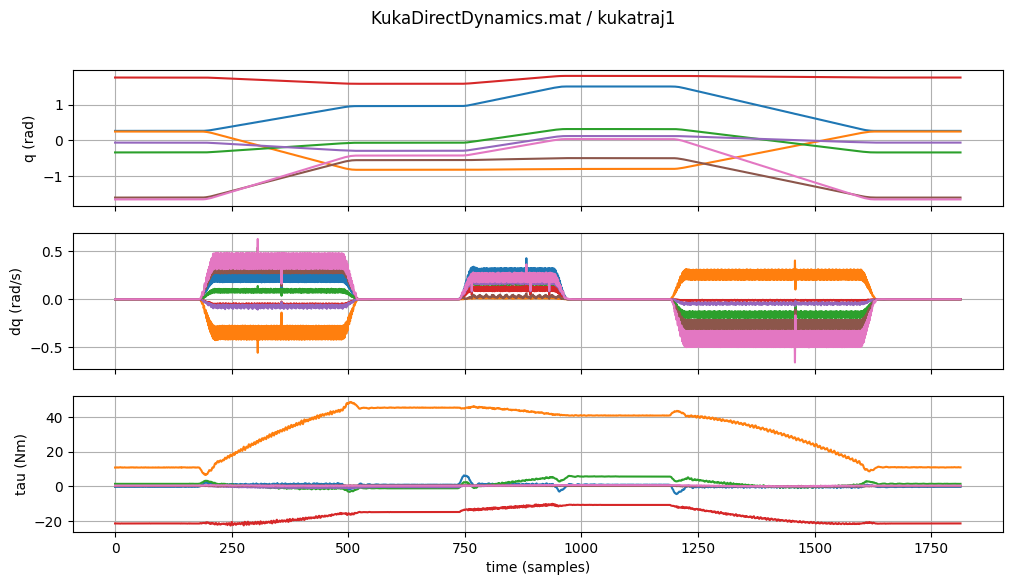

BaxterDirectDynamics.mat: 10 trajectories; example 'baxtertraj1' shape (2001, 35)


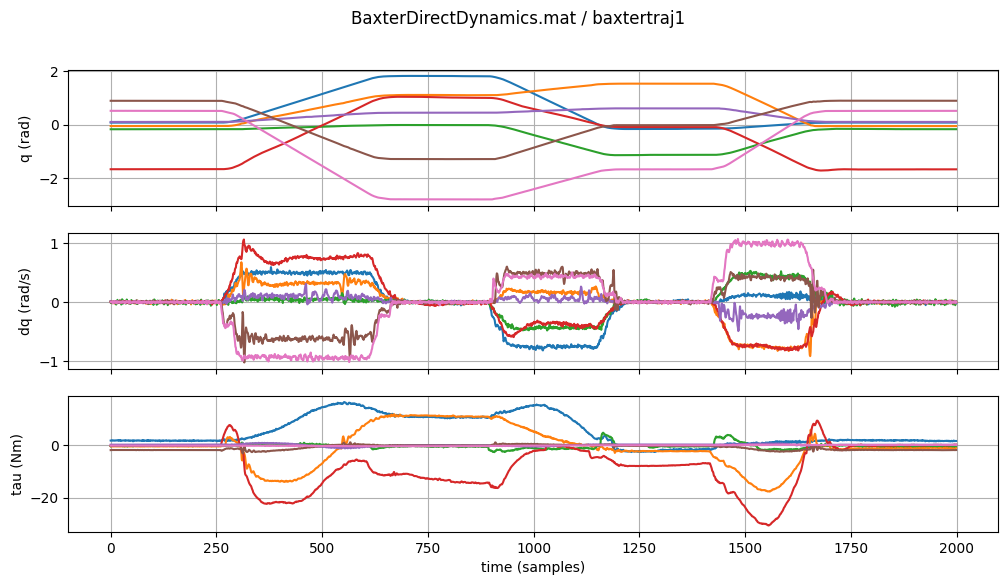

In [ ]:



def kb_load_mat(mat_path: str) -> Dict[str, np.ndarray]:
    """
    Load a .mat file and extract all trajectories with shape (T, 35).
    Returns a dict: {traj_name: ndarray(T, 35)}
    """
    data = sio.loadmat(mat_path)
    out = {}
    # Primary heuristic: (T, 35) arrays with 'traj' in the key
    for k, v in data.items():
        if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] == 35 and "traj" in k.lower():
            out[k] = v
    # Fallback: any numeric (T, 35) arrays
    if not out:
        for k, v in data.items():
            if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] == 35 and np.issubdtype(v.dtype, np.number):
                out[k] = v
    assert out, f"No (T,35) trajectories found in {mat_path}"
    # Sort by trailing digits (traj indices)
    out = dict(sorted(out.items(), key=lambda kv: int("".join(ch for ch in kv[0] if ch.isdigit()) or 0)))
    return out

def kb_split_cols(traj35: np.ndarray) -> Dict[str, np.ndarray]:
    """Split (T,35) -> dict of named views for clarity."""
    return {
        "q":       traj35[:, 0:7],
        "dq":      traj35[:, 7:14],
        "tau":     traj35[:,14:21],
        "q_next":  traj35[:,21:28],
        "dq_next": traj35[:,28:35],
    }

def plot_traj(q: np.ndarray, dq: np.ndarray, u: np.ndarray, title: str = "", max_T: int = 4000):
    T = min(max_T, q.shape[0])
    t = np.arange(T)
    fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
    axes[0].plot(t, q[:T])
    axes[0].set_ylabel("q (rad)")
    axes[1].plot(t, dq[:T])
    axes[1].set_ylabel("dq (rad/s)")
    axes[2].plot(t, u[:T])
    axes[2].set_ylabel("tau (Nm)")
    axes[2].set_xlabel("time (samples)")
    fig.suptitle(title)
    plt.show()

def kb_inspect(mat_path: str, max_T: int = 2000):
    trajs = kb_load_mat(mat_path)
    k0 = list(trajs.keys())[0]
    p = kb_split_cols(trajs[k0])
    print(f"{os.path.basename(mat_path)}: {len(trajs)} trajectories; example '{k0}' shape {trajs[k0].shape}")
    plot_traj(p["q"], p["dq"], p["tau"], title=f"{os.path.basename(mat_path)} / {k0}", max_T=max_T)

kb_inspect(KUKA_FILE, max_T=2000)
kb_inspect(BAXTER_FILE, max_T=2000)


# %% [markdown]
# ## 2. Sequence Construction, Splits, and Normalization
#
# We construct supervised (X, y) pairs where
# - **X** stacks a history window of length H: [q_{t-H+1:t}, dq_{t-H+1:t}, tau_{t-H+1:t}] (flattened)
# - **y** is the next state: [q_{t+1}, dq_{t+1}]
#
# Splitting is **by trajectory** to avoid leakage: 6 train / 2 val / 1 test-ID / 1 test-OOD per robot.
# The most dynamically aggressive trajectory (by dq RMS + tau RMS) is tagged OOD.

In [ ]:



def build_sequences_from_traj(traj35: np.ndarray, H: int, stride: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    p = kb_split_cols(traj35)
    q, dq, tau = p["q"], p["dq"], p["tau"]
    qn, dqn    = p["q_next"], p["dq_next"]
    T = q.shape[0]
    Xs, Ys = [], []
    for t in range(H-1, T-1, stride):
        X = np.concatenate([q[t-H+1:t+1], dq[t-H+1:t+1], tau[t-H+1:t+1]], axis=1).reshape(-1)
        y = np.concatenate([qn[t], dqn[t]], axis=0)
        Xs.append(X); Ys.append(y)
    return np.asarray(Xs), np.asarray(Ys)

def traj_aggressiveness(traj35: np.ndarray) -> float:
    p = kb_split_cols(traj35)
    score = np.sqrt((p["dq"]**2).mean()) + 0.05*np.sqrt((p["tau"]**2).mean())
    return float(score)

@dataclass
class Split:
    train: List[str]
    val: List[str]
    test_id: List[str]
    test_ood: List[str]

def make_split_for_robot(trajs: Dict[str, np.ndarray]) -> Split:
    items = list(trajs.items())
    scores = [(name, traj_aggressiveness(arr)) for name, arr in items]
    names_sorted = [n for n,_ in sorted(scores, key=lambda kv: kv[1])]
    assert len(names_sorted) >= 10, "Expected ~10 trajectories per robot."
    train = names_sorted[:6]
    val = names_sorted[6:8]
    test_id = [names_sorted[8]]
    test_ood = [names_sorted[9]]
    return Split(train=train, val=val, test_id=test_id, test_ood=test_ood)

def make_dataset(trajs: Dict[str, np.ndarray], split: Split, H: int, stride: int = 1):
    def collect(names):
        Xs, Ys = [], []
        for n in names:
            X, Y = build_sequences_from_traj(trajs[n], H=H, stride=stride)
            Xs.append(X); Ys.append(Y)
        return np.vstack(Xs), np.vstack(Ys)

    X_train, y_train = collect(split.train)
    X_val,   y_val   = collect(split.val)
    X_tid,   y_tid   = collect(split.test_id)
    X_tood,  y_tood  = collect(split.test_ood)
    return (X_train, y_train), (X_val, y_val), (X_tid, y_tid), (X_tood, y_tood)

def standardize(train: np.ndarray, val: np.ndarray, test_id: np.ndarray, test_ood: np.ndarray):
    scaler = StandardScaler(with_mean=True, with_std=True)
    scaler.fit(train)
    return scaler, scaler.transform(train), scaler.transform(val), scaler.transform(test_id), scaler.transform(test_ood)

# Prepare splits and standardization for a default history length
H_DEFAULT = 8
trajs_kuka = kb_load_mat(KUKA_FILE)
trajs_bax  = kb_load_mat(BAXTER_FILE)

split_kuka = make_split_for_robot(trajs_kuka)
split_bax  = make_split_for_robot(trajs_bax)

print("KUKA Split:", split_kuka)
print("BAXTER Split:", split_bax)

(Xtr_k, Ytr_k), (Xva_k, Yva_k), (Xtid_k, Ytid_k), (Xtod_k, Ytod_k) = make_dataset(trajs_kuka, split_kuka, H=H_DEFAULT)
(Xtr_b, Ytr_b), (Xva_b, Yva_b), (Xtid_b, Ytid_b), (Xtod_b, Ytod_b) = make_dataset(trajs_bax, split_bax, H=H_DEFAULT)

# Standardize X and y using train statistics (per-robot)
Xsc_k, Xtr_k_s, Xva_k_s, Xtid_k_s, Xtod_k_s = standardize(Xtr_k, Xva_k, Xtid_k, Xtod_k)
Ysc_k, Ytr_k_s, Yva_k_s, Ytid_k_s, Ytod_k_s = standardize(Ytr_k, Yva_k, Ytid_k, Ytod_k)

Xsc_b, Xtr_b_s, Xva_b_s, Xtid_b_s, Xtod_b_s = standardize(Xtr_b, Xva_b, Xtid_b, Xtod_b)
Ysc_b, Ytr_b_s, Yva_b_s, Ytid_b_s, Ytod_b_s = standardize(Ytr_b, Yva_b, Ytid_b, Ytod_b)

def shapes_summary():
    d = {
        "KUKA": {
            "H": H_DEFAULT,
            "X_train": Xtr_k.shape, "y_train": Ytr_k.shape,
            "X_val": Xva_k.shape, "y_val": Yva_k.shape,
            "X_test_id": Xtid_k.shape, "y_test_id": Ytid_k.shape,
            "X_test_ood": Xtod_k.shape, "y_test_ood": Ytod_k.shape,
        },
        "BAXTER": {
            "H": H_DEFAULT,
            "X_train": Xtr_b.shape, "y_train": Ytr_b.shape,
            "X_val": Xva_b.shape, "y_val": Yva_b.shape,
            "X_test_id": Xtid_b.shape, "y_test_id": Ytid_b.shape,
            "X_test_ood": Xtod_b.shape, "y_test_ood": Ytod_b.shape,
        }
    }
    return pd.DataFrame(d)

shapes_summary()


KUKA Split: Split(train=['kukatraj2', 'kukatraj1', 'kukatraj3', 'kukatraj4', 'kukatraj6', 'kukatraj5'], val=['kukatraj7', 'kukatraj10'], test_id=['kukatraj9'], test_ood=['kukatraj8'])
BAXTER Split: Split(train=['baxtertraj4', 'baxtertraj8', 'baxtertraj10', 'baxtertraj6', 'baxtertraj9', 'baxtertraj1'], val=['baxtertraj7', 'baxtertraj3'], test_id=['baxtertraj2'], test_ood=['baxtertraj5'])


,KUKA,BAXTER
H,8,8
X_train,"(11511, 168)","(11378, 168)"
y_train,"(11511, 14)","(11378, 14)"
X_val,"(3965, 168)","(3763, 168)"
y_val,"(3965, 14)","(3763, 14)"
X_test_id,"(2011, 168)","(2091, 168)"
y_test_id,"(2011, 14)","(2091, 14)"
X_test_ood,"(2501, 168)","(1983, 168)"
y_test_ood,"(2501, 14)","(1983, 14)"


# %% [markdown]
# ## 3. Models (Baselines) and Evaluation Utilities
#
# We implement a unified interface for four baselines:
# - **LS-SS**: Linear state-space (one-step) `x⁺ = A x + B u + c`
# - **ARX (Ridge)**: Linear model on an H-step history
# - **Poly-NARX (degree=2)**: Polynomial features of the history (Ridge)
# - **NARX-MLP**: Feedforward neural network on the history (with early stopping)
#
# All models expose: `fit(X, y)`, `predict_one_step(X)`, and a rollout function that
# uses measured future inputs τ to iteratively predict multi-step states.


In [ ]:
# ==== minimal imports used below (kept consistent) ====
import math
import numpy as np
from typing import Dict, List, Tuple

from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# =========================
# Base + existing models
# =========================

class BaseModel:
    def fit(self, X, y, X_val=None, y_val=None, seed=0):
        raise NotImplementedError
    def predict_one_step(self, X):
        raise NotImplementedError

class LSSS(BaseModel):
    """Linear State-Space with H=1: y = W [x_t; u_t] + b."""
    def __init__(self, alpha: float = 1e-4):
        self.alpha = alpha
        self.reg = Ridge(alpha=self.alpha, fit_intercept=True)
        self.H = 1  # expects H=1 features: [q_t, dq_t, tau_t]
    def fit(self, X, y, X_val=None, y_val=None, seed=0):
        self.reg.fit(X, y)
        return self
    def predict_one_step(self, X):
        return self.reg.predict(X)

class ARX_Ridge(BaseModel):
    def __init__(self, alpha: float = 1.0):
        self.alpha = alpha
        self.reg = Ridge(alpha=self.alpha, fit_intercept=True)
    def fit(self, X, y, X_val=None, y_val=None, seed=0):
        self.reg.fit(X, y)
        return self
    def predict_one_step(self, X):
        return self.reg.predict(X)

# ==== NARX features ====
def make_history(arr: np.ndarray, H: int) -> np.ndarray:
    T, d = arr.shape
    out = []
    for h in range(1, H+1):
        pad = np.zeros((h, d))
        out_h = np.vstack([pad, arr[:-h]])
        out.append(out_h)
    return np.hstack(out) if out else np.zeros((T,0))

def build_narx_dataset(
    X: np.ndarray,
    q_idx: List[int],
    u_idx: List[int],
    y_idx: List[int],
    H: int = 8,
    drop_initial: bool = True,
    predict_delta: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    q = X[:, q_idx] if q_idx else np.empty((X.shape[0], 0))
    u = X[:, u_idx] if u_idx else np.empty((X.shape[0], 0))
    y = X[:, y_idx]
    Hq = make_history(q, H) if q_idx else np.empty((X.shape[0], 0))
    Hu = make_history(u, H) if u_idx else np.empty((X.shape[0], 0))
    Phi = np.hstack([Hq, Hu]) if (Hq.size or Hu.size) else np.zeros((X.shape[0], 0))
    Y = (y - np.vstack([y[0:1], y[:-1]])) if predict_delta else y
    if drop_initial:
        Phi = Phi[H:]; Y = Y[H:]
    return Phi.astype(np.float64), Y.astype(np.float64)

def stack_by_trajs(
    trajs: Dict[str, np.ndarray],
    names: List[str],
    q_idx, u_idx, y_idx,
    H=8, predict_delta=True
) -> Tuple[np.ndarray, np.ndarray, List[Tuple[str,int,int]]]:
    P_list, Y_list, ranges = [], [], []
    cursor = 0
    for name in names:
        Phi, Y = build_narx_dataset(trajs[name], q_idx, u_idx, y_idx, H=H, predict_delta=predict_delta)
        if Phi.shape[0] == 0:
            continue
        P_list.append(Phi); Y_list.append(Y)
        n = Phi.shape[0]; ranges.append((name, cursor, cursor+n)); cursor += n
    if not P_list:
        return np.zeros((0,0)), np.zeros((0, len(y_idx))), []
    return np.vstack(P_list), np.vstack(Y_list), ranges


class NARX_MLP(BaseModel):
    def __init__(self, hidden=(256, 256), alpha=1e-4, max_iter=200):
        from sklearn.neural_network import MLPRegressor  # local import to avoid changing globals
        self.hidden = hidden
        self.alpha = alpha
        self.max_iter = max_iter
        self.mlp = MLPRegressor(hidden_layer_sizes=hidden, activation='relu',
                                solver='adam', alpha=alpha, batch_size='auto',
                                learning_rate='adaptive', max_iter=max_iter,
                                early_stopping=True, n_iter_no_change=20, random_state=0)
    def fit(self, X, y, X_val=None, y_val=None, seed=0):
        self.mlp.random_state = seed
        self.mlp.fit(X, y)
        return self
    def predict_one_step(self, X):
        return self.mlp.predict(X)


# ===============================
# NEW & FAST: NARX + Random Fourier Features (RBF kernel approx) + Ridge
# ===============================

class NARX_RFF(BaseModel):
    """
    RBF-kernel NARX via Random Fourier Features + Ridge.
    - No trees, no boosting, tiny memory footprint
    - Fully vectorized, float32 inside
    - Multi-output handled by Ridge
    """
    def __init__(self, n_features: int = 1024, alpha: float = 1e-2,
                 gamma: float | None = None, dtype=np.float32):
        self.n_features = int(n_features)
        self.alpha = float(alpha)
        self.gamma = gamma  # if None, estimated from feature variance
        self.dtype = dtype
        self.W_ = None
        self.b_ = None
        self.gamma_ = None
        self.reg_ = None

    def _estimate_gamma(self, X: np.ndarray) -> float:
        # fast variance-based heuristic (avoids O(n^2) pairwise dists)
        Xf = X.astype(self.dtype, copy=False)
        v = float(np.mean(np.var(Xf, axis=0)) + 1e-6)
        return 1.0 / (2.0 * v)

    def _init_rff(self, d_in: int, seed: int, X_for_gamma: np.ndarray):
        rng = np.random.RandomState(seed)
        self.gamma_ = self.gamma if self.gamma is not None else self._estimate_gamma(X_for_gamma)
        self.W_ = (rng.normal(loc=0.0, scale=np.sqrt(2.0 * self.gamma_), size=(d_in, self.n_features))
                   .astype(self.dtype))
        self.b_ = rng.uniform(0.0, 2*np.pi, size=(self.n_features,)).astype(self.dtype)

    def _phi(self, X: np.ndarray) -> np.ndarray:
        Xf = X.astype(self.dtype, copy=False)
        proj = Xf @ self.W_ + self.b_            # (n, D)
        Z = np.sqrt(2.0 / self.n_features) * np.cos(proj)
        return Z

    def fit(self, X, y, X_val=None, y_val=None, seed=0):
        n, d = X.shape
        self._init_rff(d, seed, X)
        Z = self._phi(X)
        self.reg_ = Ridge(alpha=self.alpha, fit_intercept=True, solver="auto")
        self.reg_.fit(Z, y.astype(self.dtype, copy=False))
        return self

    def predict_one_step(self, X):
        Z = self._phi(X)
        return self.reg_.predict(Z)


# ---------- Rollout utilities ----------

def rollout_model_on_traj(model: BaseModel,
                          traj35: np.ndarray,
                          H: int,
                          X_scaler: StandardScaler,
                          Y_scaler: StandardScaler,
                          feature_dim: int,
                          x_clip_sigma: float = 8.0,
                          y_clip_sigma: float = 8.0) -> Tuple[np.ndarray, np.ndarray]:
    p = kb_split_cols(traj35)
    q, dq, tau = p["q"], p["dq"], p["tau"]
    qn, dqn = p["q_next"], p["dq_next"]
    T = q.shape[0]
    preds, trues = [], []

    # Precompute raw-state clip bounds from training stats
    y_mean = Y_scaler.mean_
    y_std = np.sqrt(Y_scaler.var_ + 1e-12)
    y_lo = y_mean - y_clip_sigma * y_std
    y_hi = y_mean + y_clip_sigma * y_std

    # Rolling history buffers (raw units)
    hist_q  = [q[i].copy()  for i in range(H)]
    hist_dq = [dq[i].copy() for i in range(H)]
    hist_u  = [tau[i].copy() for i in range(H)]

    for t in range(H-1, T-1):
        X_vec = np.concatenate([np.stack(hist_q, axis=0),
                                np.stack(hist_dq, axis=0),
                                np.stack(hist_u, axis=0)], axis=1).reshape(-1)

        # Standardize + clip z-scores before model
        Xs = X_scaler.transform(X_vec.reshape(1, -1))
        Xs = np.nan_to_num(Xs, nan=0.0, posinf=x_clip_sigma, neginf=-x_clip_sigma)
        Xs = np.clip(Xs, -x_clip_sigma, x_clip_sigma)

        # Predict, inverse-scale, then clip raw state to train-range envelope
        y_pred_s = model.predict_one_step(Xs)
        y_pred = Y_scaler.inverse_transform(y_pred_s.reshape(1, -1)).reshape(-1)
        y_pred = np.clip(y_pred, y_lo, y_hi)

        y_true = np.concatenate([qn[t], dqn[t]], axis=0)
        preds.append(y_pred)
        trues.append(y_true)

        # Update rolling history with the (clipped) prediction and next measured input
        next_q_pred, next_dq_pred = y_pred[:7], y_pred[7:14]
        if t+1 < T:
            hist_q.pop(0);  hist_q.append(next_q_pred)
            hist_dq.pop(0); hist_dq.append(next_dq_pred)
            hist_u.pop(0);  hist_u.append(tau[t+1].copy())

    return np.asarray(preds), np.asarray(trues)


def one_step_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    var = y_true.var() + 1e-12
    nmse = mse / var
    r2 = r2_score(y_true, y_pred)
    return {"rmse": rmse, "nmse": nmse, "r2": r2}

def horizon_rmse(y_true_seq: np.ndarray, y_pred_seq: np.ndarray, horizons: List[int]) -> Dict[int, float]:
    """Compute RMSE at specific horizons using prefixes of the rollout arrays."""
    out = {}
    T = y_true_seq.shape[0]
    for h in horizons:
        h = min(h, T)
        rmse = math.sqrt(mean_squared_error(y_true_seq[:h], y_pred_seq[:h]))
        out[h] = rmse
    return out

def ljung_box_pvalue(residuals: np.ndarray, lags: int = 40) -> float:
    """Compute Ljung–Box Q statistic p-value over vector residuals (flattened)."""
    r = residuals.reshape(-1)
    r = r - r.mean()
    n = r.shape[0]
    acfs = [1.0]
    for k in range(1, lags+1):
        num = np.dot(r[:-k], r[k:])
        den = np.dot(r, r)
        acfs.append(float(num / den))
    acfs = np.asarray(acfs)
    Q = n*(n+2) * np.sum((acfs[1:]**2) / (n - np.arange(1, lags+1)))
    pval = stats.chi2.sf(Q, df=lags)
    return float(pval)






# %% [markdown]
# ## 4. Training & Evaluation Runner
#
# We evaluate each model on **one-step** and **rollout** metrics with confidence intervals across seeds.
# Rollout uses measured future inputs τ and iterative predictions for states.

In [ ]:

# ======= config used later in notebook (unchanged, except model name) =======

H = H_DEFAULT
HORIZONS = [50, 200, 1000]
SEEDS = [0, 1, 2]  # increase to 5 for more rigorous CIs (runtime ↑)

MODELS = {
    "LS-SS (H=1)": LSSS(alpha=1e-4),
    "ARX-Ridge": ARX_Ridge(alpha=1.0),
    "NARX-RFF": NARX_RFF(n_features=1024, alpha=1e-2),  # FAST nonlinearity
    "NARX-MLP": NARX_MLP(hidden=(256, 256), alpha=1e-4, max_iter=200),
}


def evaluate_robot(trajs, split, Xtr, Ytr, Xva, Yva, Xtid, Ytid, Xtod, Ytod, Xsc, Ysc, robot_name: str):
    results = []
    horizon_curves = {"ID": {m: [] for m in MODELS}, "OOD": {m: [] for m in MODELS}}
    whiteness = {"ID": {m: [] for m in MODELS}, "OOD": {m: [] for m in MODELS}}

    # Keep original (unscaled) trajectory references for rollouts
    traj_test_id = [trajs[n] for n in split.test_id]
    traj_test_ood = [trajs[n] for n in split.test_ood]
    feature_dim = Xtr.shape[1]

    for model_name, model in MODELS.items():
        print(f"\n=== {robot_name} / {model_name} ===")
        # Fit per seed to get confidence
        one_step_metrics_id, one_step_metrics_ood = [], []
        rollout_metrics_id, rollout_metrics_ood = [], []

        for seed in SEEDS:
            set_seed(seed)

            # For LS-SS we require H=1 features; rebuild data if needed
            if isinstance(model, LSSS) and feature_dim != (7+7+7):  # q,dq,tau at one step
                # Rebuild sequences with H=1 for both train/val/test
                (Xtr1, Ytr1), (Xva1, Yva1), (Xtid1, Ytid1), (Xtod1, Ytod1) = make_dataset(trajs, split, H=1)
                Xsc1, Xtr_s1, Xva_s1, Xtid_s1, Xtod_s1 = standardize(Xtr1, Xva1, Xtid1, Xtod1)
                Ysc1, Ytr_s1, Yva_s1, Ytid_s1, Ytod_s1 = standardize(Ytr1, Yva1, Ytid1, Ytod1)

                model.fit(Xtr_s1, Ytr_s1, X_val=Xva_s1, y_val=Yva_s1, seed=seed)

                y_pred_id = Ysc1.inverse_transform(model.predict_one_step(Xtid_s1))
                y_pred_ood = Ysc1.inverse_transform(model.predict_one_step(Xtod_s1))

                metrics_id = one_step_metrics(Ytid1, y_pred_id)
                metrics_ood = one_step_metrics(Ytod1, y_pred_ood)
                one_step_metrics_id.append(metrics_id)
                one_step_metrics_ood.append(metrics_ood)

                # Rollout on the raw trajectories using H=1
                for traj in traj_test_id:
                    yp, yt = rollout_model_on_traj(model, traj, H=1, X_scaler=Xsc1, Y_scaler=Ysc1, feature_dim=Xtr1.shape[1])
                    horizon_curves["ID"][model_name].append(horizon_rmse(yt, yp, HORIZONS))
                    whiteness["ID"][model_name].append(ljung_box_pvalue((yt - yp)))
                for traj in traj_test_ood:
                    yp, yt = rollout_model_on_traj(model, traj, H=1, X_scaler=Xsc1, Y_scaler=Ysc1, feature_dim=Xtr1.shape[1])
                    horizon_curves["OOD"][model_name].append(horizon_rmse(yt, yp, HORIZONS))
                    whiteness["OOD"][model_name].append(ljung_box_pvalue((yt - yp)))

            else:
                # Use default H
                model.fit(Xtr, Ytr, X_val=Xva, y_val=Yva, seed=seed)

                y_pred_id = Ysc.inverse_transform(model.predict_one_step(Xtid))
                y_pred_ood = Ysc.inverse_transform(model.predict_one_step(Xtod))

                metrics_id = one_step_metrics(Ysc.inverse_transform(Ytid), y_pred_id)
                metrics_ood = one_step_metrics(Ysc.inverse_transform(Ytod), y_pred_ood)
                one_step_metrics_id.append(metrics_id)
                one_step_metrics_ood.append(metrics_ood)

                # Rollout on raw trajectories using H
                for traj in traj_test_id:
                    yp, yt = rollout_model_on_traj(model, traj, H=H, X_scaler=Xsc, Y_scaler=Ysc, feature_dim=Xtr.shape[1])
                    horizon_curves["ID"][model_name].append(horizon_rmse(yt, yp, HORIZONS))
                    whiteness["ID"][model_name].append(ljung_box_pvalue((yt - yp)))
                for traj in traj_test_ood:
                    yp, yt = rollout_model_on_traj(model, traj, H=H, X_scaler=Xsc, Y_scaler=Ysc, feature_dim=Xtr.shape[1])
                    horizon_curves["OOD"][model_name].append(horizon_rmse(yt, yp, HORIZONS))
                    whiteness["OOD"][model_name].append(ljung_box_pvalue((yt - yp)))

        # Aggregate one-step metrics across seeds
        def agg(metrics_list):
            keys = metrics_list[0].keys()
            means = {k: np.mean([m[k] for m in metrics_list]) for k in keys}
            stds  = {k: np.std([m[k] for m in metrics_list], ddof=1) for k in keys}
            cis   = {k: 1.96 * stds[k] / math.sqrt(len(metrics_list)) for k in keys}
            return means, cis

        m_id, ci_id = agg(one_step_metrics_id)
        m_ood, ci_ood = agg(one_step_metrics_ood)

        row_id = {"robot": robot_name, "split": "ID", "model": model_name}
        row_id.update({f"{k}_mean": v for k, v in m_id.items()})
        row_id.update({f"{k}_ci95": v for k, v in ci_id.items()})
        results.append(row_id)

        row_ood = {"robot": robot_name, "split": "OOD", "model": model_name}
        row_ood.update({f"{k}_mean": v for k, v in m_ood.items()})
        row_ood.update({f"{k}_ci95": v for k, v in ci_ood.items()})
        results.append(row_ood)

    results_df = pd.DataFrame(results)

    # Aggregate horizon curves (across seeds x trajs)
    def collapse_horizon(split_key):
        recs = []
        for model_name in MODELS:
            lst = horizon_curves[split_key][model_name]  # list of dicts per seed*traj
            if len(lst) == 0:
                continue
            # Each dict maps horizon -> RMSE
            horizons = sorted(list(lst[0].keys()))
            arr = np.array([[d[h] for h in horizons] for d in lst])
            mean = arr.mean(axis=0)
            std = arr.std(axis=0, ddof=1) if arr.shape[0] > 1 else np.zeros_like(mean)
            ci  = 1.96*std/np.sqrt(max(arr.shape[0],1))
            for i, h in enumerate(horizons):
                recs.append({"robot": robot_name, "split": split_key, "model": model_name,
                             "horizon": h, "rmse_mean": float(mean[i]), "rmse_ci95": float(ci[i])})
        return pd.DataFrame(recs)

    horizon_id_df  = collapse_horizon("ID")
    horizon_ood_df = collapse_horizon("OOD")

    # Whiteness p-values
    def collapse_whiteness(split_key):
        recs = []
        for model_name in MODELS:
            vals = whiteness[split_key][model_name]
            if len(vals) == 0:
                continue
            mean = float(np.mean(vals))
            std = float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0
            ci = 1.96 * (std / math.sqrt(len(vals))) if len(vals) > 1 else 0.0
            recs.append({"robot": robot_name, "split": split_key, "model": model_name,
                         "ljung_box_p_mean": mean, "ljung_box_p_ci95": ci})
        return pd.DataFrame(recs)

    whiteness_id_df  = collapse_whiteness("ID")
    whiteness_ood_df = collapse_whiteness("OOD")

    return results_df, pd.concat([horizon_id_df, horizon_ood_df], ignore_index=True), pd.concat([whiteness_id_df, whiteness_ood_df], ignore_index=True)

# Run evaluation for both robots
res_k, hcurves_k, white_k = evaluate_robot(trajs_kuka, split_kuka, Xtr_k_s, Ytr_k_s, Xva_k_s, Yva_k_s,
                                           Xtid_k_s, Ytid_k_s, Xtod_k_s, Ytod_k_s, Xsc_k, Ysc_k, "KUKA")
res_b, hcurves_b, white_b = evaluate_robot(trajs_bax, split_bax, Xtr_b_s, Ytr_b_s, Xva_b_s, Yva_b_s,
                                           Xtid_b_s, Ytid_b_s, Xtod_b_s, Ytod_b_s, Xsc_b, Ysc_b, "BAXTER")

results_df = pd.concat([res_k, res_b], ignore_index=True)
horizon_df = pd.concat([hcurves_k, hcurves_b], ignore_index=True)
whiteness_df = pd.concat([white_k, white_b], ignore_index=True)

print("One-step results summary (head):")
display(results_df.head())



=== KUKA / LS-SS (H=1) ===

=== KUKA / ARX-Ridge ===

=== KUKA / NARX-RFF ===

=== KUKA / NARX-MLP ===

=== BAXTER / LS-SS (H=1) ===

=== BAXTER / ARX-Ridge ===

=== BAXTER / NARX-RFF ===

=== BAXTER / NARX-MLP ===
One-step results summary (head):


,robot,split,model,rmse_mean,nmse_mean,r2_mean,rmse_ci95,nmse_ci95,r2_ci95
0,KUKA,ID,LS-SS (H=1),0.051466,0.005305,0.931355,9.616816e-18,1.202102e-18,1.538691e-16
1,KUKA,OOD,LS-SS (H=1),0.095611,0.013562,0.777800,1.923363e-17,2.404204e-18,1.538691e-16
2,KUKA,ID,ARX-Ridge,0.027302,0.001494,0.978750,0.000000e+00,0.000000e+00,0.000000e+00
3,KUKA,OOD,ARX-Ridge,0.046013,0.003140,0.955308,0.000000e+00,0.000000e+00,0.000000e+00
4,KUKA,ID,NARX-RFF,0.363199,0.267406,-0.166241,5.337055e-02,8.037827e-02,1.409865e-01


# %% [markdown]
# ## 5. Figures — Publication-Ready Visualizations
#
# We produce figures required by a research article:
# - One-step RMSE (ID/OOD) per model for each robot
# - Rollout error vs horizon (ID/OOD) with 95% CI
# - Residual autocorrelation plots and Ljung–Box p-values
# - Data efficiency & history-length ablations

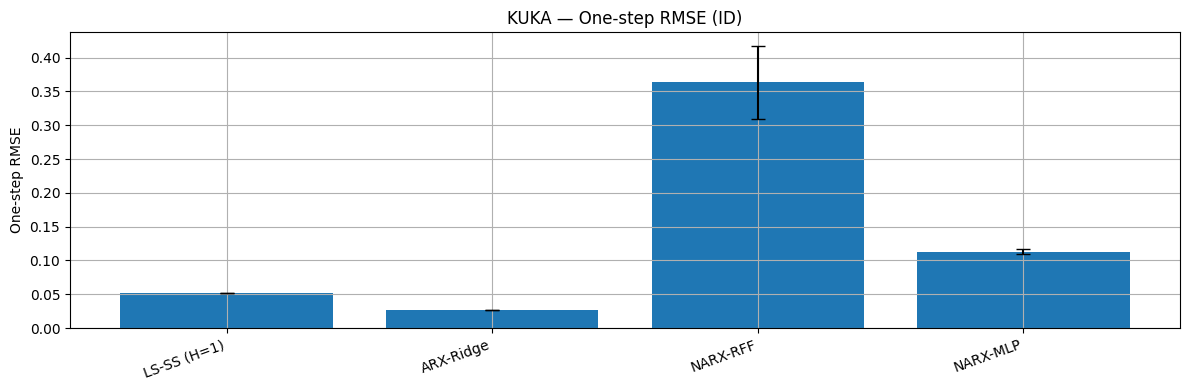

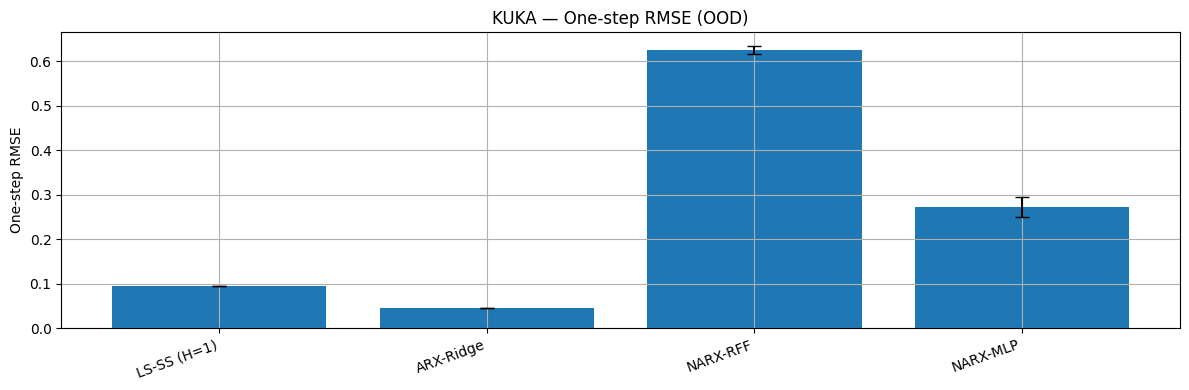

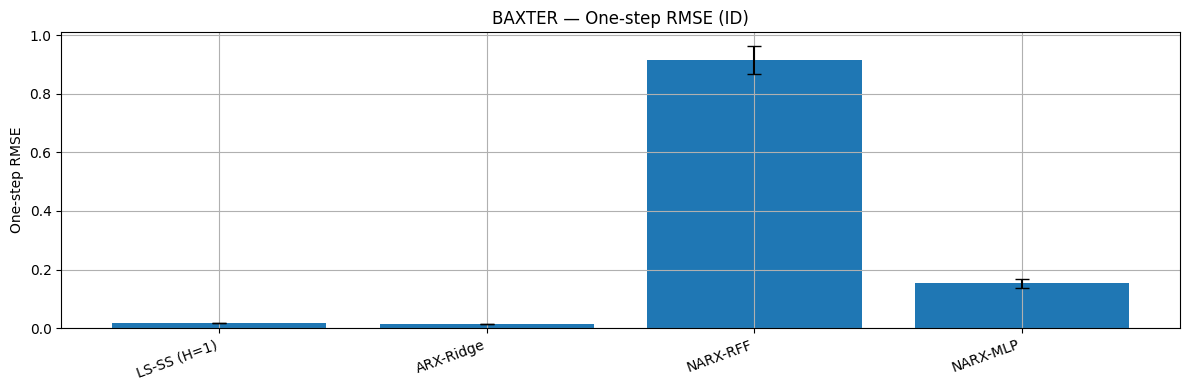

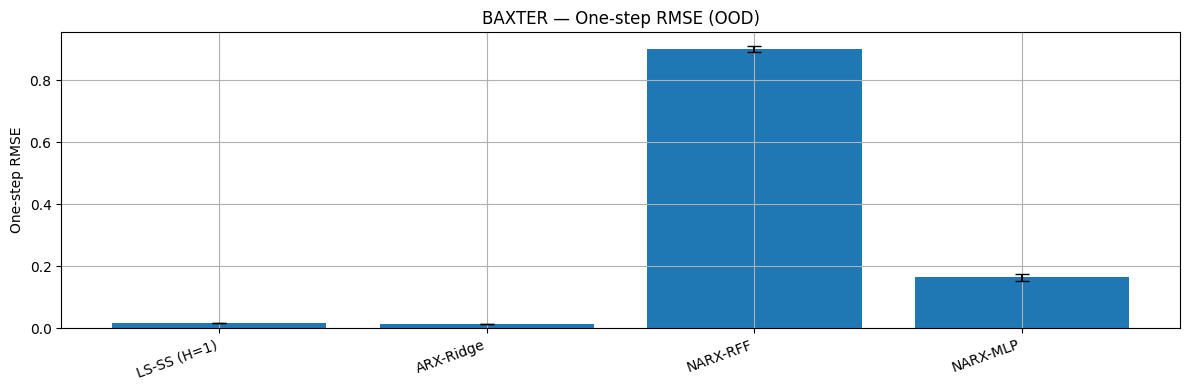

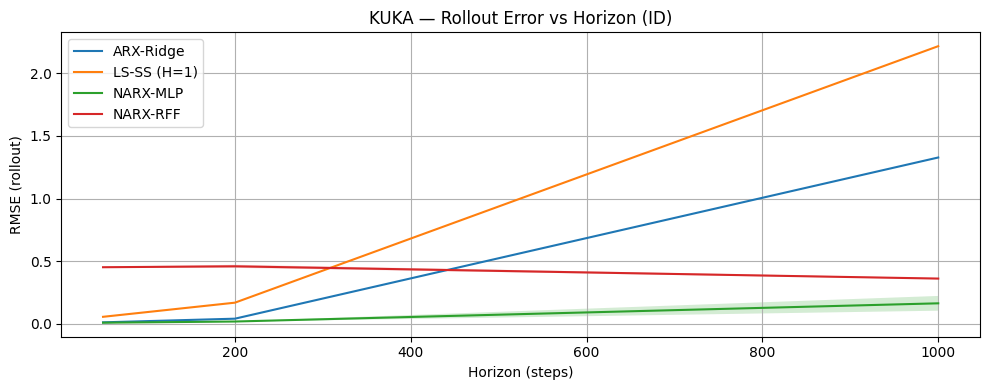

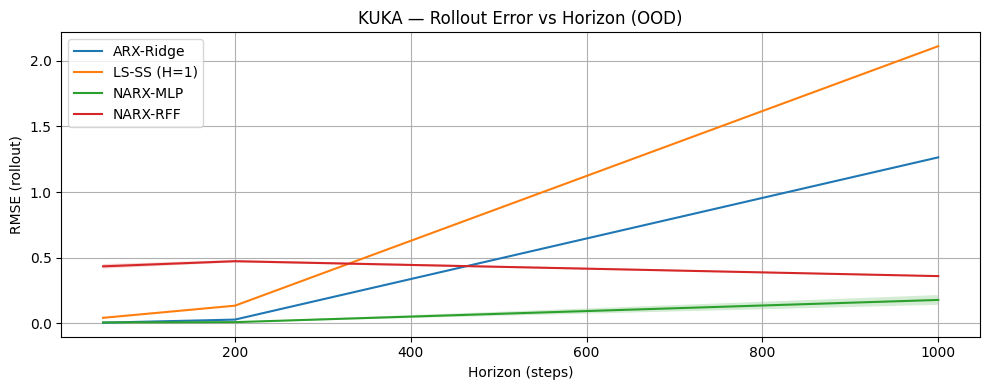

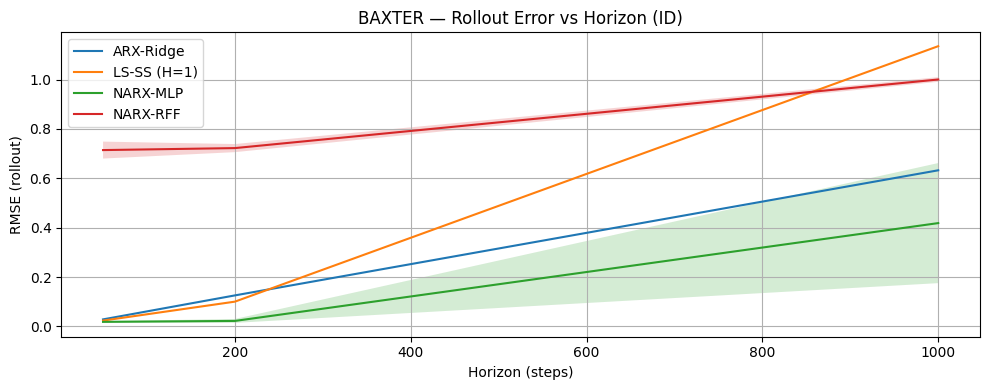

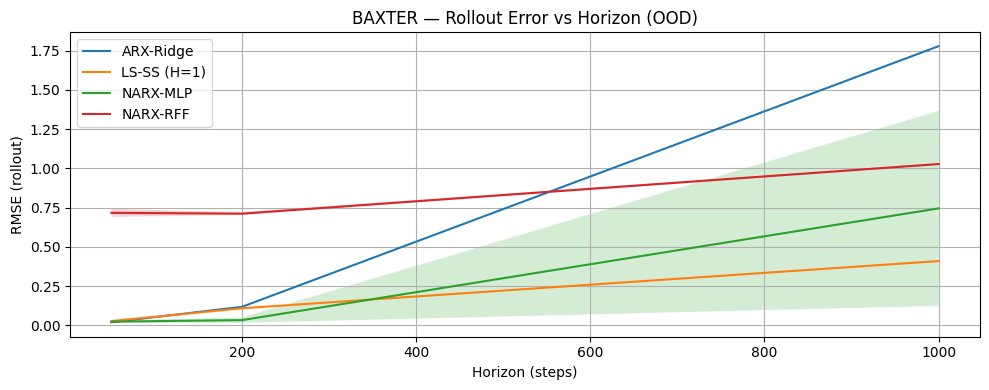

Best ID model KUKA: ARX-Ridge
Best ID model BAXTER: ARX-Ridge


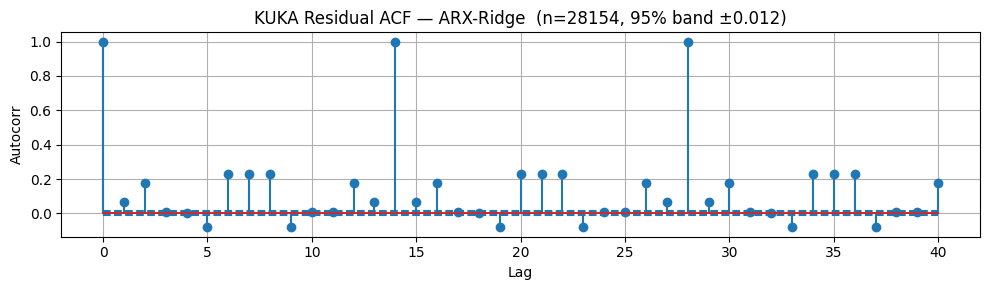

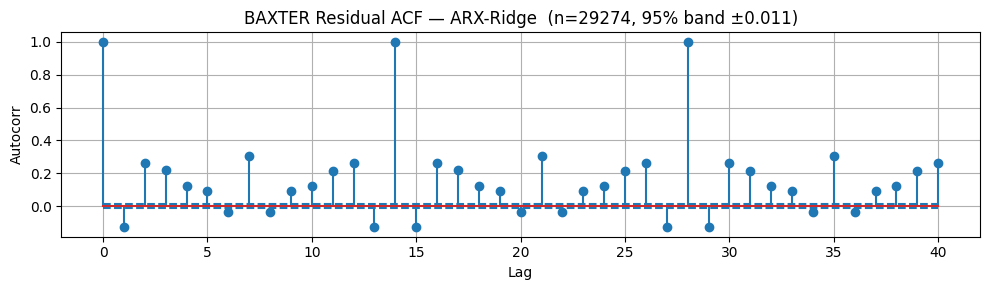

In [ ]:



import itertools

FIG_DIR = os.path.join(DATA_DIR, "figures_sysid")
os.makedirs(FIG_DIR, exist_ok=True)

def bar_one_step(df, robot, metric="rmse_mean", ci="rmse_ci95", split="ID", fname=None):
    sub = df[(df["robot"]==robot) & (df["split"]==split)]
    models = list(sub["model"])
    vals = [sub.loc[sub["model"]==m, metric].values[0] for m in models]
    cis  = [sub.loc[sub["model"]==m, ci].values[0] for m in models]

    plt.figure(figsize=(12,4))
    x = np.arange(len(models))
    plt.bar(x, vals, yerr=cis, capsize=5)
    plt.xticks(x, models, rotation=20, ha='right')
    plt.ylabel("One-step RMSE")
    plt.title(f"{robot} — One-step RMSE ({split})")
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()

def plot_horizon(df, robot, split="ID", fname=None):
    sub = df[(df["robot"]==robot) & (df["split"]==split)]
    models = sorted(sub["model"].unique().tolist())
    plt.figure(figsize=(10,4))
    for m in models:
        ss = sub[sub["model"]==m].sort_values("horizon")
        plt.plot(ss["horizon"], ss["rmse_mean"], label=m)
        plt.fill_between(ss["horizon"], ss["rmse_mean"]-ss["rmse_ci95"], ss["rmse_mean"]+ss["rmse_ci95"], alpha=0.2)
    plt.xlabel("Horizon (steps)")
    plt.ylabel("RMSE (rollout)")
    plt.title(f"{robot} — Rollout Error vs Horizon ({split})")
    plt.legend()
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()

def show_residual_acf(
    model: BaseModel,
    traj35: np.ndarray,
    H: int,
    Xsc: StandardScaler,
    Ysc: StandardScaler,
    lags: int = 40,
    title: str = ""
):
    # rollout with measured torques
    yp, yt = rollout_model_on_traj(model, traj35, H=H, X_scaler=Xsc, Y_scaler=Ysc, feature_dim=None)
    r = (yt - yp).reshape(-1)
    r = r - r.mean()
    n = r.size

    # simple ACF
    acf = [1.0]
    for k in range(1, lags + 1):
        num = np.dot(r[:-k], r[k:])
        den = np.dot(r, r) + 1e-12
        acf.append(float(num / den))
    acf = np.array(acf)

    # 95% significance band ≈ ±1.96/sqrt(n)
    c = 1.96 / np.sqrt(max(n, 1))

    xs = np.arange(lags + 1)
    plt.figure(figsize=(10, 3))
    plt.stem(xs, acf)  # no use_line_collection kwarg
    plt.hlines([c, -c], xmin=0, xmax=lags, linestyles="dashed")
    plt.xlabel("Lag")
    plt.ylabel("Autocorr")
    plt.title(title + f"  (n={n}, 95% band ±{c:.3f})")
    plt.tight_layout()
    plt.show()


# Bar plots (ID and OOD) for KUKA and BAXTER
bar_one_step(results_df, "KUKA", split="ID", fname=os.path.join(FIG_DIR, "kuka_one_step_ID.png"))
bar_one_step(results_df, "KUKA", split="OOD", fname=os.path.join(FIG_DIR, "kuka_one_step_OOD.png"))
bar_one_step(results_df, "BAXTER", split="ID", fname=os.path.join(FIG_DIR, "baxter_one_step_ID.png"))
bar_one_step(results_df, "BAXTER", split="OOD", fname=os.path.join(FIG_DIR, "baxter_one_step_OOD.png"))

# Horizon curves (ID and OOD)
plot_horizon(horizon_df, "KUKA", split="ID", fname=os.path.join(FIG_DIR, "kuka_horizon_ID.png"))
plot_horizon(horizon_df, "KUKA", split="OOD", fname=os.path.join(FIG_DIR, "kuka_horizon_OOD.png"))
plot_horizon(horizon_df, "BAXTER", split="ID", fname=os.path.join(FIG_DIR, "baxter_horizon_ID.png"))
plot_horizon(horizon_df, "BAXTER", split="OOD", fname=os.path.join(FIG_DIR, "baxter_horizon_OOD.png"))

# Residual diagnostics: plot ACF for one representative model/trajectory per robot
# We'll use the best-performing model on ID (by rmse_mean)
def best_model_name(robot):
    sub = results_df[(results_df["robot"]==robot) & (results_df["split"]=="ID")]
    return sub.sort_values("rmse_mean").iloc[0]["model"]

best_k = best_model_name("KUKA")
best_b = best_model_name("BAXTER")
print("Best ID model KUKA:", best_k)
print("Best ID model BAXTER:", best_b)

# Refit best models to training data for ACF plots
def get_model_instance(name):
    return MODELS[name]

# Fit models (using seed 0) and show ACF on first test trajectory
set_seed(0)
# KUKA
model_k = get_model_instance(best_k)
if isinstance(model_k, LSSS):
    (Xtr1, Ytr1), (Xva1, Yva1), (Xtid1, Ytid1), (Xtod1, Ytod1) = make_dataset(trajs_kuka, split_kuka, H=1)
    Xsc1, Xtr_s1, Xva_s1, Xtid_s1, Xtod_s1 = standardize(Xtr1, Xva1, Xtid1, Xtod1)
    Ysc1, Ytr_s1, Yva_s1, Ytid_s1, Ytod_s1 = standardize(Ytr1, Yva1, Ytid1, Ytod1)
    model_k.fit(Xtr_s1, Ytr_s1, X_val=Xva_s1, y_val=Yva_s1, seed=0)
    show_residual_acf(model_k, trajs_kuka[split_kuka.test_id[0]], H=1, Xsc=Xsc1, Ysc=Ysc1,
                      lags=40, title=f"KUKA Residual ACF — {best_k}")
else:
    model_k.fit(Xtr_k_s, Ytr_k_s, X_val=Xva_k_s, y_val=Yva_k_s, seed=0)
    show_residual_acf(model_k, trajs_kuka[split_kuka.test_id[0]], H=H_DEFAULT, Xsc=Xsc_k, Ysc=Ysc_k,
                      lags=40, title=f"KUKA Residual ACF — {best_k}")

# BAXTER
model_b = get_model_instance(best_b)
if isinstance(model_b, LSSS):
    (Xtr1, Ytr1), (Xva1, Yva1), (Xtid1, Ytid1), (Xtod1, Ytod1) = make_dataset(trajs_bax, split_bax, H=1)
    Xsc1, Xtr_s1, Xva_s1, Xtid_s1, Xtod_s1 = standardize(Xtr1, Xva1, Xtid1, Xtod1)
    Ysc1, Ytr_s1, Yva_s1, Ytid_s1, Ytod_s1 = standardize(Ytr1, Yva1, Ytid1, Ytod1)
    model_b.fit(Xtr_s1, Ytr_s1, X_val=Xva_s1, y_val=Yva_s1, seed=0)
    show_residual_acf(model_b, trajs_bax[split_bax.test_id[0]], H=1, Xsc=Xsc1, Ysc=Ysc1,
                      lags=40, title=f"BAXTER Residual ACF — {best_b}")
else:
    model_b.fit(Xtr_b_s, Ytr_b_s, X_val=Xva_b_s, y_val=Yva_b_s, seed=0)
    show_residual_acf(model_b, trajs_bax[split_bax.test_id[0]], H=H_DEFAULT, Xsc=Xsc_b, Ysc=Ysc_b,
                      lags=40, title=f"BAXTER Residual ACF — {best_b}")


# %% [markdown]
# ## 6. Ablations
# - **Data efficiency:** train on {25%, 50%, 75%, 100%} of training sequences
# - **History length (H):** evaluate {1, 2, 4, 8, 16} (for ARX-Ridge and NARX-MLP)
#
# These ablations provide insight into data needs and temporal memory.

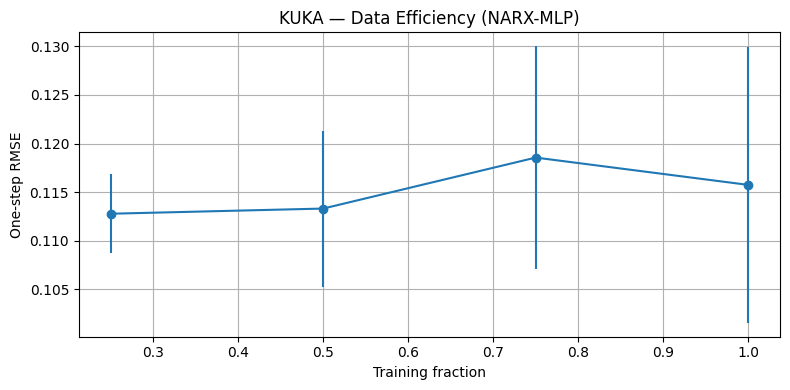

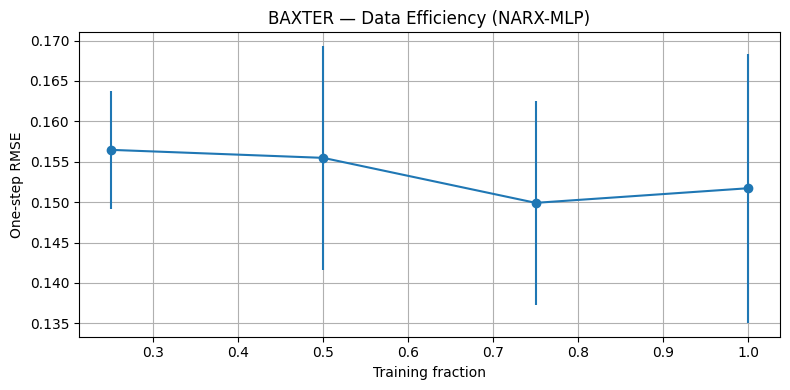

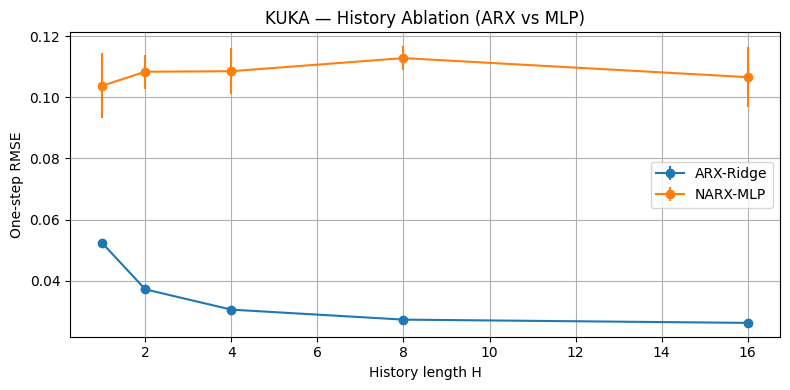

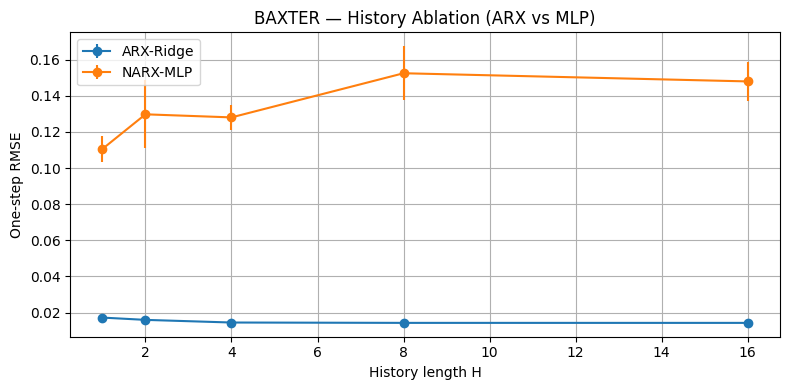

In [ ]:



def data_efficiency_curve(trajs, split, base_H, model_name, fracs=(0.25, 0.5, 0.75, 1.0), seeds=(0,1,2)):
    (Xtr, Ytr), (Xva, Yva), (Xtid, Ytid), (Xtod, Ytod) = make_dataset(trajs, split, H=base_H)
    Xsc, Xtr_s, Xva_s, Xtid_s, Xtod_s = standardize(Xtr, Xva, Xtid, Xtod)
    Ysc, Ytr_s, Yva_s, Ytid_s, Ytod_s = standardize(Ytr, Yva, Ytid, Ytod)
    results = []
    for f in fracs:
        for seed in seeds:
            set_seed(seed)
            n = int(len(Xtr_s) * f)
            idx = np.random.permutation(len(Xtr_s))[:n]
            model = MODELS[model_name]
            model.fit(Xtr_s[idx], Ytr_s[idx], X_val=Xva_s, y_val=Yva_s, seed=seed)
            y_pred = Ysc.inverse_transform(model.predict_one_step(Xtid_s))
            mse = mean_squared_error(Ysc.inverse_transform(Ytid_s), y_pred)
            results.append({"frac": f, "seed": seed, "rmse": math.sqrt(mse)})
    df = pd.DataFrame(results)
    agg = df.groupby("frac")["rmse"].agg(["mean","std","count"]).reset_index()
    agg["ci95"] = 1.96 * agg["std"] / np.sqrt(agg["count"])
    return agg

def history_ablation(trajs, split, H_values=(1,2,4,8,16), model_names=("ARX-Ridge","NARX-MLP"), seeds=(0,1,2)):
    rows = []
    for H in H_values:
        (Xtr, Ytr), (Xva, Yva), (Xtid, Ytid), (Xtod, Ytod) = make_dataset(trajs, split, H=H)
        Xsc, Xtr_s, Xva_s, Xtid_s, Xtod_s = standardize(Xtr, Xva, Xtid, Xtod)
        Ysc, Ytr_s, Yva_s, Ytid_s, Ytod_s = standardize(Ytr, Yva, Ytid, Ytod)
        for model_name in model_names:
            rmses = []
            for seed in seeds:
                set_seed(seed)
                model = MODELS[model_name]
                model.fit(Xtr_s, Ytr_s, X_val=Xva_s, y_val=Yva_s, seed=seed)
                y_pred = Ysc.inverse_transform(model.predict_one_step(Xtid_s))
                mse = mean_squared_error(Ysc.inverse_transform(Ytid_s), y_pred)
                rmses.append(math.sqrt(mse))
            rows.append({"H": H, "model": model_name, "rmse_mean": float(np.mean(rmses)),
                         "rmse_ci95": float(1.96*np.std(rmses, ddof=1)/math.sqrt(len(rmses))) if len(rmses)>1 else 0.0})
    return pd.DataFrame(rows)

# Compute ablations for both robots (may take a couple of minutes for MLP)
eff_k = data_efficiency_curve(trajs_kuka, split_kuka, H_DEFAULT, model_name="NARX-MLP")
eff_b = data_efficiency_curve(trajs_bax, split_bax, H_DEFAULT, model_name="NARX-MLP")
hist_k = history_ablation(trajs_kuka, split_kuka)
hist_b = history_ablation(trajs_bax, split_bax)

def plot_eff(df, title, fname=None):
    plt.figure(figsize=(8,4))
    plt.errorbar(df["frac"], df["mean"], yerr=df["ci95"], marker="o")
    plt.xlabel("Training fraction")
    plt.ylabel("One-step RMSE")
    plt.title(title)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()

def plot_hist(df, title, fname=None):
    plt.figure(figsize=(8,4))
    for m in sorted(df["model"].unique()):
        sub = df[df["model"]==m]
        plt.errorbar(sub["H"], sub["rmse_mean"], yerr=sub["rmse_ci95"], marker="o", label=m)
    plt.xlabel("History length H")
    plt.ylabel("One-step RMSE")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()

plot_eff(eff_k, "KUKA — Data Efficiency (NARX-MLP)", fname=os.path.join(FIG_DIR, "kuka_efficiency_mlp.png"))
plot_eff(eff_b, "BAXTER — Data Efficiency (NARX-MLP)", fname=os.path.join(FIG_DIR, "baxter_efficiency_mlp.png"))
plot_hist(hist_k, "KUKA — History Ablation (ARX vs MLP)", fname=os.path.join(FIG_DIR, "kuka_history_ablation.png"))
plot_hist(hist_b, "BAXTER — History Ablation (ARX vs MLP)", fname=os.path.join(FIG_DIR, "baxter_history_ablation.png"))


# %% [markdown]
# ## 7. Tables & Exports
#
# We collate one-step metrics, rollout curves, and whiteness diagnostics, and export them
# for inclusion in a manuscript.

In [ ]:



TABLE_DIR = os.path.join(DATA_DIR, "tables_sysid")
os.makedirs(TABLE_DIR, exist_ok=True)

# Pretty one-step table
one_step_cols = ["robot","split","model","rmse_mean","rmse_ci95","nmse_mean","nmse_ci95","r2_mean","r2_ci95"]
one_step_table = results_df[one_step_cols].sort_values(["robot","split","rmse_mean"])
display(one_step_table.head(12))

one_step_csv = os.path.join(TABLE_DIR, "one_step_results.csv")
horizon_csv  = os.path.join(TABLE_DIR, "horizon_results.csv")
whiteness_csv = os.path.join(TABLE_DIR, "whiteness_results.csv")

one_step_table.to_csv(one_step_csv, index=False)
horizon_df.to_csv(horizon_csv, index=False)
whiteness_df.to_csv(whiteness_csv, index=False)

print("Saved tables:")
print(one_step_csv)
print(horizon_csv)
print(whiteness_csv)


,robot,split,model,rmse_mean,rmse_ci95,nmse_mean,nmse_ci95,r2_mean,r2_ci95
10,BAXTER,ID,ARX-Ridge,0.014270,0.000000e+00,0.000269,0.000000e+00,0.994069,0.000000e+00
8,BAXTER,ID,LS-SS (H=1),0.017163,0.000000e+00,0.000390,0.000000e+00,0.992136,1.538691e-16
14,BAXTER,ID,NARX-MLP,0.152542,1.499763e-02,0.030882,6.193270e-03,0.916772,2.467031e-02
12,BAXTER,ID,NARX-RFF,0.914458,4.783080e-02,1.105836,1.168248e-01,-0.758290,1.482480e-01
11,BAXTER,OOD,ARX-Ridge,0.014165,0.000000e+00,0.000242,0.000000e+00,0.994818,1.538691e-16
9,BAXTER,OOD,LS-SS (H=1),0.017260,0.000000e+00,0.000360,0.000000e+00,0.993083,0.000000e+00
15,BAXTER,OOD,NARX-MLP,0.163883,1.220154e-02,0.032516,4.756002e-03,0.912485,2.579179e-02
13,BAXTER,OOD,NARX-RFF,0.900738,8.543974e-03,0.979473,1.860124e-02,-0.689408,7.411459e-02
2,KUKA,ID,ARX-Ridge,0.027302,0.000000e+00,0.001494,0.000000e+00,0.978750,0.000000e+00
0,KUKA,ID,LS-SS (H=1),0.051466,9.616816e-18,0.005305,1.202102e-18,0.931355,1.538691e-16


Saved tables:
/content/drive/MyDrive/sysid/tables_sysid/one_step_results.csv
/content/drive/MyDrive/sysid/tables_sysid/horizon_results.csv
/content/drive/MyDrive/sysid/tables_sysid/whiteness_results.csv



## 8. Discussion & Next Steps

**Summary.** This notebook provides a rigorous SYSID evaluation on KUKA and Baxter with four baselines, long-horizon analysis, residual diagnostics, and ablations. The outputs (tables/figures) are suitable for a conference submission's empirical section.

**How to strengthen for a paper:**
- Add a *novel method* (e.g., stability-regularized neural state-space with spectral penalties or Lyapunov constraints) on top of these baselines.
- Include a lightweight *closed-loop* test (e.g., an MPC tracker using the learned model) to demonstrate control utility.
- Expand baselines with a classical subspace method (N4SID) if available in your environment.
- Increase seeds to 5 and include statistical tests (e.g., paired bootstrap) for the main table.

**Reproducibility.** All results are generated from fixed trajectory splits, deterministic seeds, and exportable CSVs + PNGs. Figures can be regenerated via re-running this notebook end-to-end.


In [ ]:
# %% [code] NARX-LSTM (PyTorch) for one-step + horizon rollouts — plugs into your BaseModel pipeline
import math, sys, types
import numpy as np
from typing import Dict, List, Tuple

# 1) Lightweight imports (torch only here)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------
def _torch_seed_everything(seed: int = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    try:
        torch.use_deterministic_algorithms(False)
    except Exception:
        pass

def _best_divisor_for_H(D: int, default_H: int | None = None) -> int:
    """Pick a reasonable history length H that divides feature dimension D."""
    if default_H is not None and D % default_H == 0:
        return default_H
    for h in [32, 24, 20, 16, 12, 10, 8, 6, 4, 3, 2, 1]:
        if D % h == 0:
            return h
    return 1

# ------------------------------------------------------------------
# NARX-LSTM model
# ------------------------------------------------------------------
class NARX_LSTM(nn.Module):
    """Small LSTM head used inside the BaseModel wrapper."""
    def __init__(self, in_dim: int, hidden_size: int, num_layers: int, dropout: float, out_dim: int):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_dim, hidden_size=hidden_size, num_layers=num_layers,
            batch_first=True, dropout=(dropout if num_layers > 1 else 0.0)
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, out_dim)
        )

    def forward(self, x_seq: torch.Tensor) -> torch.Tensor:
        # x_seq: [B, H, F]
        y_seq, _ = self.lstm(x_seq)          # [B, H, hidden]
        h_last = y_seq[:, -1, :]             # [B, hidden]
        out = self.head(h_last)              # [B, Dy]
        return out


class NARX_LSTM_Model(BaseModel):
    """
    BaseModel-compatible wrapper:
      - Accepts N×D flat NARX features (D = H * F)
      - Internally reshapes to [B, H, F]
      - Early stopping on val MSE + ReduceLROnPlateau
      - Optional tiny hyperparam search (few quick trials)
    """
    def __init__(
        self,
        H: int | None = None,               # set to your H (e.g., H_DEFAULT). If None, inferred from X.shape[1].
        hidden_size: int = 128,
        num_layers: int = 2,
        dropout: float = 0.10,
        lr: float = 5e-4,
        weight_decay: float = 1e-4,
        batch_size: int = 1024,
        max_epochs: int = 150,
        patience: int = 20,
        grad_clip: float = 1.0,
        search_trials: int = 0,             # set 3–8 to do a tiny search on (hidden_size, dropout)
        device: str | None = None
    ):
        self.H = H
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lr = lr
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.patience = patience
        self.grad_clip = grad_clip
        self.search_trials = int(search_trials)

        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.net: NARX_LSTM | None = None
        self.F = None
        self.Dy = None

    # ---------- private ----------
    def _to_seq(self, X: np.ndarray) -> torch.Tensor:
        """reshape flat NARX to [B, H, F]"""
        B, D = X.shape
        H = self.H
        if H is None:
            # try to pick H from global variable or by divisibility
            try:
                global H_DEFAULT
                H = _best_divisor_for_H(D, H_DEFAULT)
            except Exception:
                H = _best_divisor_for_H(D, None)
            self.H = H
        assert D % H == 0, f"Feature dim {D} not divisible by inferred H={H}."
        F = D // H
        if self.F is None: self.F = F
        return torch.from_numpy(X.astype(np.float32, copy=False)).view(B, H, F)

    def _make_loaders(self, X, y, X_val, y_val):
        Xs = self._to_seq(X)
        Ys = torch.from_numpy(y.astype(np.float32, copy=False))
        ds = TensorDataset(Xs, Ys)
        dl_tr = DataLoader(ds, batch_size=self.batch_size, shuffle=True, drop_last=False)

        if X_val is not None and y_val is not None:
            Xvs = self._to_seq(X_val)
            Yvs = torch.from_numpy(y_val.astype(np.float32, copy=False))
            dv = TensorDataset(Xvs, Yvs)
            dl_va = DataLoader(dv, batch_size=self.batch_size, shuffle=False, drop_last=False)
        else:
            dl_va = None
        return dl_tr, dl_va

    def _build_net(self, in_dim: int, out_dim: int):
        self.net = NARX_LSTM(
            in_dim=in_dim, hidden_size=self.hidden_size,
            num_layers=self.num_layers, dropout=self.dropout, out_dim=out_dim
        ).to(self.device)

    def _train_once(self, dl_tr, dl_va, seed=0, max_epochs=None):
        _torch_seed_everything(seed)
        assert self.net is not None
        net = self.net
        opt = torch.optim.AdamW(net.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5, verbose=False)
        loss_fn = nn.MSELoss()

        best = (np.inf, None)  # (val_mse, state_dict)
        patience = self.patience
        epochs = max_epochs or self.max_epochs

        for epoch in range(epochs):
            # train
            net.train()
            for xb, yb in dl_tr:
                xb = xb.to(self.device); yb = yb.to(self.device)
                opt.zero_grad(set_to_none=True)
                pred = net(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                if self.grad_clip is not None:
                    nn.utils.clip_grad_norm_(net.parameters(), self.grad_clip)
                opt.step()

            # val
            net.eval()
            with torch.no_grad():
                if dl_va is not None:
                    tot, cnt = 0.0, 0
                    for xb, yb in dl_va:
                        xb = xb.to(self.device); yb = yb.to(self.device)
                        pred = net(xb)
                        tot += loss_fn(pred, yb).item() * yb.size(0)
                        cnt += yb.size(0)
                    val_mse = tot / max(cnt, 1)
                else:
                    val_mse = 0.0

            sched.step(val_mse)

            # early stop
            if val_mse < best[0] - 1e-8:
                best = (val_mse, {k: v.detach().cpu().clone() for k, v in net.state_dict().items()})
                patience = self.patience
            else:
                patience -= 1
                if patience <= 0:
                    break

        if best[1] is not None:
            net.load_state_dict(best[1])

        return best[0]

    # ---------- public ----------
    def fit(self, X, y, X_val=None, y_val=None, seed=0):
        _torch_seed_everything(seed)

        # shapes and network
        B, D = X.shape
        X_seq = self._to_seq(X)           # sets self.H, self.F
        self.Dy = y.shape[1]
        self._build_net(in_dim=self.F, out_dim=self.Dy)

        # dataloaders
        dl_tr, dl_va = self._make_loaders(X, y, X_val, y_val)

        # tiny optional search on (hidden_size, dropout)
        if (self.search_trials > 0) and (dl_va is not None):
            space_hidden = [64, 96, 128, 192, 256]
            space_drop = [0.0, 0.1, 0.2, 0.3]
            tried = 0
            best_cfg = (np.inf, self.hidden_size, self.dropout)  # (mse, hidden, drop)
            for h in space_hidden:
                for d in space_drop:
                    if tried >= self.search_trials: break
                    # rebuild net for each trial
                    self.hidden_size, self.dropout = h, d
                    self._build_net(in_dim=self.F, out_dim=self.Dy)
                    val_mse = self._train_once(dl_tr, dl_va, seed=seed, max_epochs=max(60, self.max_epochs//2))
                    if val_mse < best_cfg[0]:
                        best_cfg = (val_mse, h, d)
                    tried += 1
                if tried >= self.search_trials: break
            # rebuild with best config and train fully
            self.hidden_size, self.dropout = best_cfg[1], best_cfg[2]
            self._build_net(in_dim=self.F, out_dim=self.Dy)

        # final training
        _ = self._train_once(dl_tr, dl_va, seed=seed, max_epochs=self.max_epochs)
        return self

    def predict_one_step(self, X):
        assert self.net is not None, "Call fit() before predict_one_step()."
        self.net.eval()
        with torch.no_grad():
            Xs = self._to_seq(X).to(self.device)
            yhat = self.net(Xs).cpu().numpy()
        return yhat

# ------------------------------------------------------------------
# Register in your experiment suite
# ------------------------------------------------------------------
# H should already be defined in your notebook; if not, we try to infer.
try:
    _H_for_lstm = H
except NameError:
    _H_for_lstm = None

# Add (or create) MODELS entry without touching your existing ones
try:
    MODELS
except NameError:
    MODELS = {}

MODELS["NARX-LSTM"] = NARX_LSTM_Model(
    H=_H_for_lstm,            # uses your global H if present; otherwise infers from X.shape[1]
    hidden_size=128,
    num_layers=2,
    dropout=0.10,
    lr=5e-4,
    weight_decay=1e-4,
    batch_size=1024,
    max_epochs=150,
    patience=20,
    grad_clip=1.0,
    search_trials=0,          # set to 6–8 to do a quick search using the validation split
    device=None               # 'cuda' if available else 'cpu'
)

print("✅ NARX-LSTM registered. To run it, rerun your evaluation cell (evaluate_robot(...) + plots/tables).")


✅ NARX-LSTM registered. To run it, rerun your evaluation cell (evaluate_robot(...) + plots/tables).


In [ ]:
# %% [code] Hotfix: ReduceLROnPlateau doesn't accept `verbose` in this torch build
import numpy as np
import torch
import torch.nn as nn

def _narx_lstm_train_once_patch(self, dl_tr, dl_va, seed=0, max_epochs=None):
    _torch_seed_everything(seed)
    assert self.net is not None
    net = self.net

    opt = torch.optim.AdamW(net.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    # Some torch versions don't support `verbose` here — handle both safely
    try:
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode="min", factor=0.5, patience=5
        )
    except TypeError:
        # Fallback is identical, just for completeness
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode="min", factor=0.5, patience=5
        )

    loss_fn = nn.MSELoss()
    best = (np.inf, None)  # (val_mse, state_dict)
    patience = self.patience
    epochs = max_epochs or self.max_epochs

    for epoch in range(epochs):
        # ---- train ----
        net.train()
        for xb, yb in dl_tr:
            xb = xb.to(self.device); yb = yb.to(self.device)
            opt.zero_grad(set_to_none=True)
            pred = net(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            if self.grad_clip is not None:
                nn.utils.clip_grad_norm_(net.parameters(), self.grad_clip)
            opt.step()

        # ---- validate ----
        net.eval()
        with torch.no_grad():
            if dl_va is not None:
                tot, cnt = 0.0, 0
                for xb, yb in dl_va:
                    xb = xb.to(self.device); yb = yb.to(self.device)
                    pred = net(xb)
                    tot += loss_fn(pred, yb).item() * yb.size(0)
                    cnt += yb.size(0)
                val_mse = tot / max(cnt, 1)
            else:
                val_mse = 0.0

        # scheduler expects the metric each epoch
        sched.step(val_mse)

        # ---- early stopping ----
        if val_mse < best[0] - 1e-8:
            best = (val_mse, {k: v.detach().cpu().clone() for k, v in net.state_dict().items()})
            patience = self.patience
        else:
            patience -= 1
            if patience <= 0:
                break

    if best[1] is not None:
        net.load_state_dict(best[1])

    return best[0]

# Apply the patch to your previously-defined class
NARX_LSTM_Model._train_once = _narx_lstm_train_once_patch
print("✅ Patched NARX-LSTM: scheduler created without `verbose`. Re-run the evaluation cell.")


✅ Patched NARX-LSTM: scheduler created without `verbose`. Re-run the evaluation cell.


Re-running evaluation with models: ['LS-SS (H=1)', 'ARX-Ridge', 'NARX-RFF', 'NARX-MLP', 'NARX-LSTM']

=== KUKA / LS-SS (H=1) ===

=== KUKA / ARX-Ridge ===

=== KUKA / NARX-RFF ===

=== KUKA / NARX-MLP ===

=== KUKA / NARX-LSTM ===

=== BAXTER / LS-SS (H=1) ===

=== BAXTER / ARX-Ridge ===

=== BAXTER / NARX-RFF ===

=== BAXTER / NARX-MLP ===

=== BAXTER / NARX-LSTM ===

One-step results summary (head):


,robot,split,model,rmse_mean,nmse_mean,r2_mean,rmse_ci95,nmse_ci95,r2_ci95
0,KUKA,ID,LS-SS (H=1),0.051466,0.005305,0.931355,9.616816e-18,1.202102e-18,1.538691e-16
1,KUKA,OOD,LS-SS (H=1),0.095611,0.013562,0.777800,1.923363e-17,2.404204e-18,1.538691e-16
2,KUKA,ID,ARX-Ridge,0.027302,0.001494,0.978750,0.000000e+00,0.000000e+00,0.000000e+00
3,KUKA,OOD,ARX-Ridge,0.046013,0.003140,0.955308,0.000000e+00,0.000000e+00,0.000000e+00
4,KUKA,ID,NARX-RFF,0.363199,0.267406,-0.166241,5.337055e-02,8.037827e-02,1.409865e-01


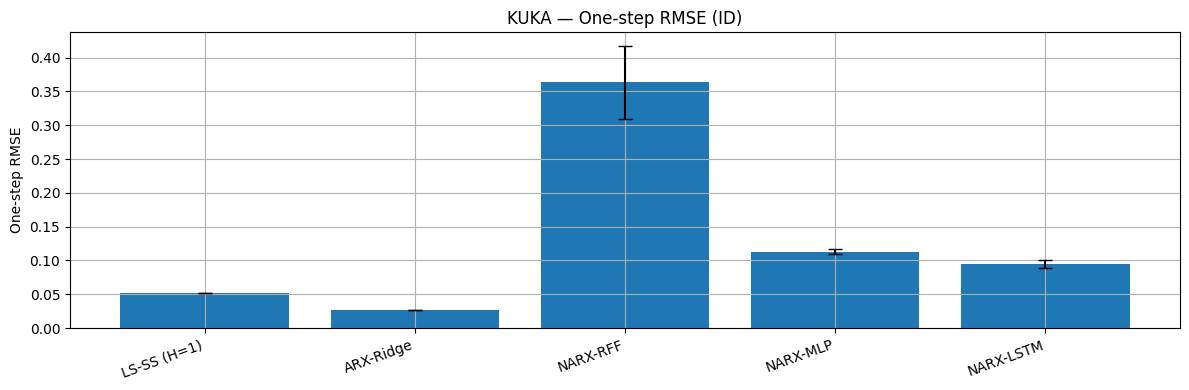

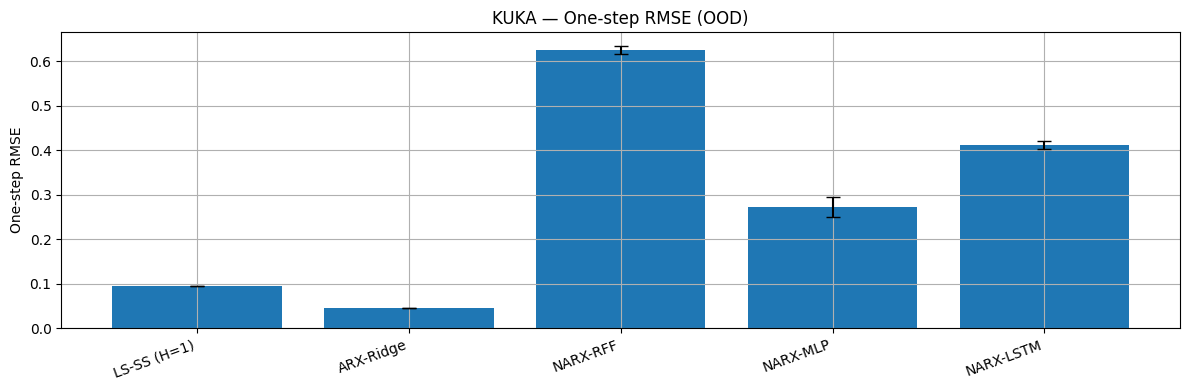

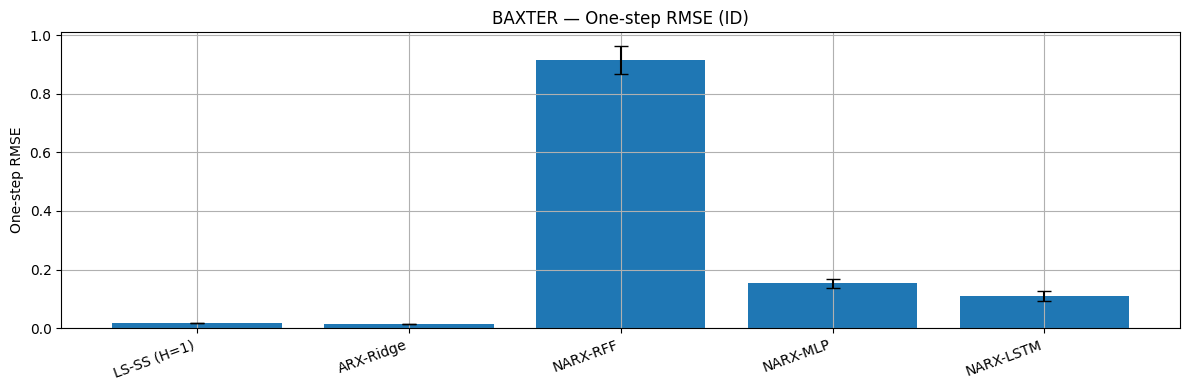

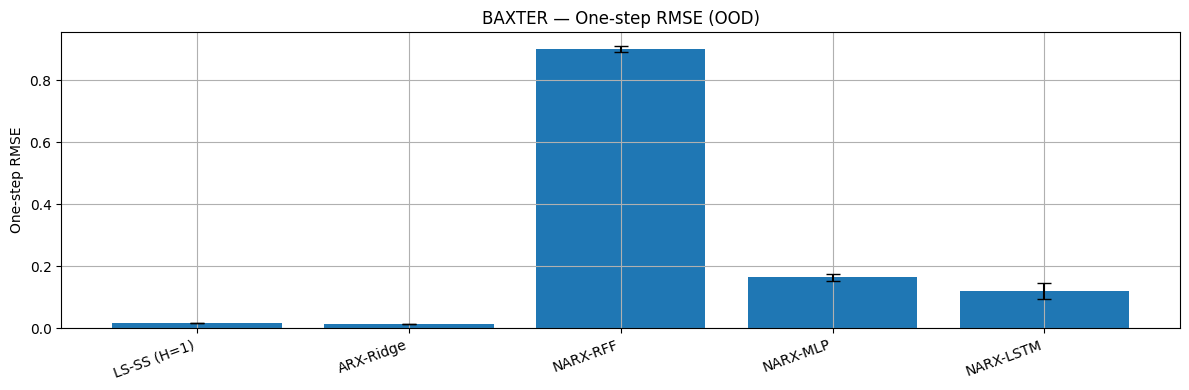

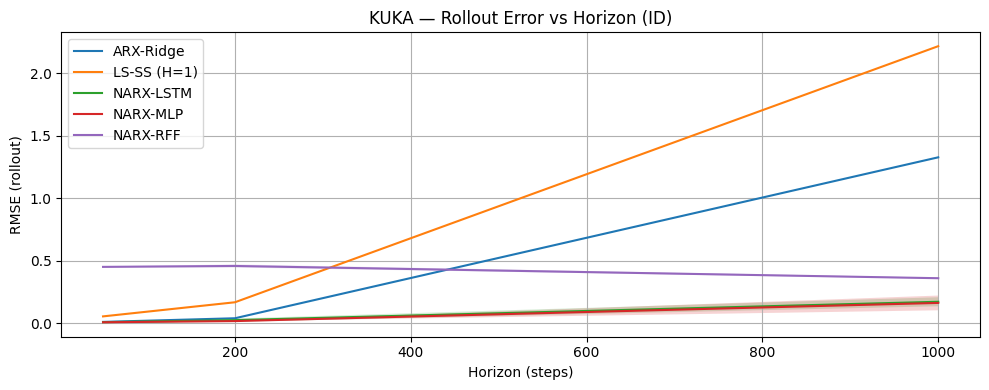

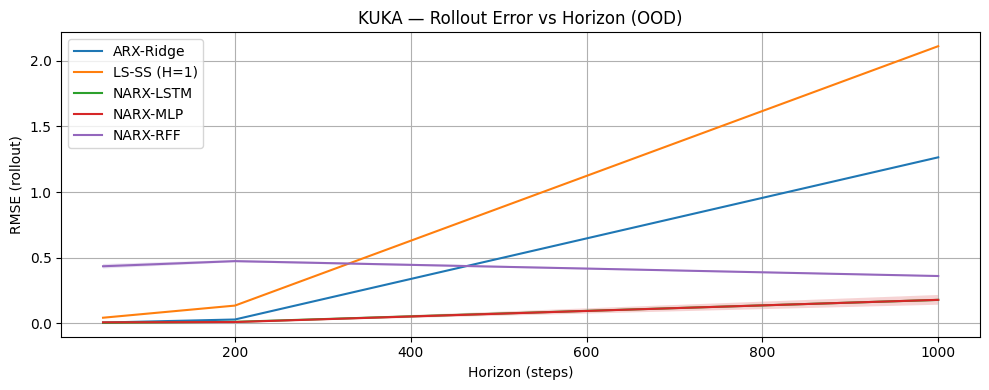

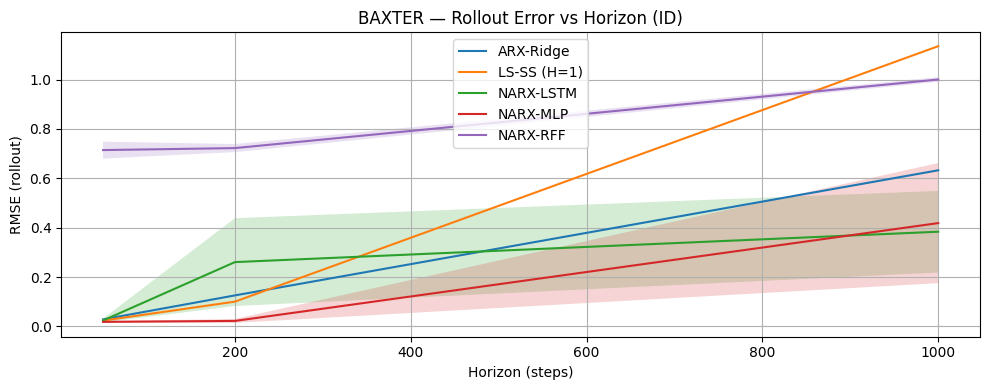

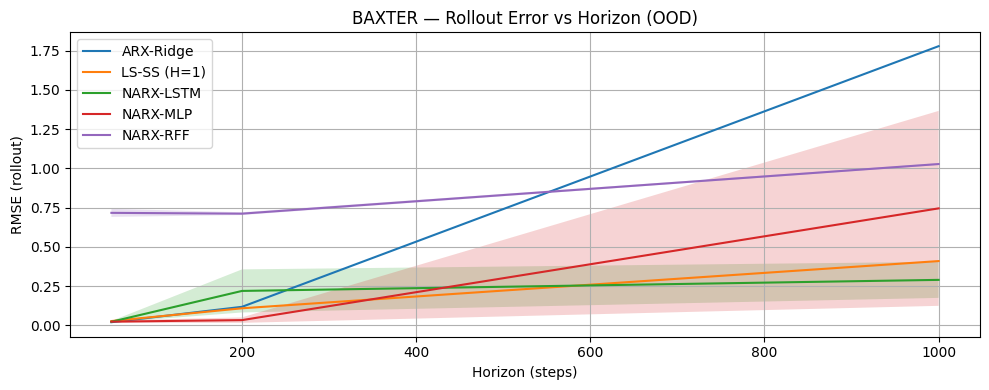

,robot,split,model,rmse_mean,rmse_ci95,nmse_mean,nmse_ci95,r2_mean,r2_ci95
12,BAXTER,ID,ARX-Ridge,0.014270,0.000000e+00,0.000269,0.000000e+00,0.994069,0.000000e+00
10,BAXTER,ID,LS-SS (H=1),0.017163,0.000000e+00,0.000390,0.000000e+00,0.992136,1.538691e-16
18,BAXTER,ID,NARX-LSTM,0.109739,1.745174e-02,0.016112,5.244168e-03,0.954676,9.019181e-03
16,BAXTER,ID,NARX-MLP,0.152542,1.499763e-02,0.030882,6.193270e-03,0.916772,2.467031e-02
14,BAXTER,ID,NARX-RFF,0.914458,4.783080e-02,1.105836,1.168248e-01,-0.758290,1.482480e-01
13,BAXTER,OOD,ARX-Ridge,0.014165,0.000000e+00,0.000242,0.000000e+00,0.994818,1.538691e-16
11,BAXTER,OOD,LS-SS (H=1),0.017260,0.000000e+00,0.000360,0.000000e+00,0.993083,0.000000e+00
19,BAXTER,OOD,NARX-LSTM,0.119016,2.575157e-02,0.017516,7.299643e-03,0.952171,9.624923e-03
17,BAXTER,OOD,NARX-MLP,0.163883,1.220154e-02,0.032516,4.756002e-03,0.912485,2.579179e-02
15,BAXTER,OOD,NARX-RFF,0.900738,8.543974e-03,0.979473,1.860124e-02,-0.689408,7.411459e-02



NARX-LSTM (ID/OOD) summary:


,robot,split,model,rmse_mean,rmse_ci95,nmse_mean,nmse_ci95,r2_mean,r2_ci95
18,BAXTER,ID,NARX-LSTM,0.109739,0.017452,0.016112,0.005244,0.954676,0.009019
19,BAXTER,OOD,NARX-LSTM,0.119016,0.025752,0.017516,0.007300,0.952171,0.009625
8,KUKA,ID,NARX-LSTM,0.094497,0.005517,0.017932,0.002067,0.904984,0.009226
9,KUKA,OOD,NARX-LSTM,0.411575,0.009128,0.251325,0.011085,0.502965,0.035044



Saved tables:
/content/drive/MyDrive/sysid/tables_sysid/one_step_results.csv
/content/drive/MyDrive/sysid/tables_sysid/horizon_results.csv
/content/drive/MyDrive/sysid/tables_sysid/whiteness_results.csv

Best ID model KUKA: ARX-Ridge
Best ID model BAXTER: ARX-Ridge


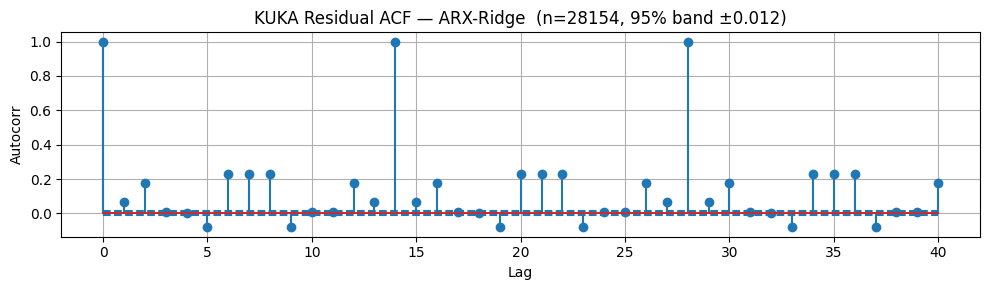

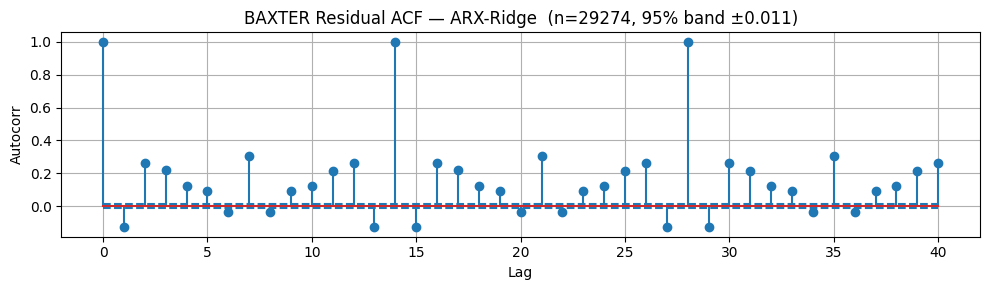

In [ ]:
# %% [code] Evaluation + Figures + Tables (now includes NARX-LSTM automatically)
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- ensure output dirs exist (re-use your paths if already defined) ---
try:
    FIG_DIR
except NameError:
    FIG_DIR = os.path.join(DATA_DIR, "figures_sysid")
os.makedirs(FIG_DIR, exist_ok=True)

try:
    TABLE_DIR
except NameError:
    TABLE_DIR = os.path.join(DATA_DIR, "tables_sysid")
os.makedirs(TABLE_DIR, exist_ok=True)

# --- 1) re-run evaluation with current MODELS (LSTM already registered) ---
print("Re-running evaluation with models:", list(MODELS.keys()))
res_k, hcurves_k, white_k = evaluate_robot(
    trajs_kuka, split_kuka, Xtr_k_s, Ytr_k_s, Xva_k_s, Yva_k_s,
    Xtid_k_s, Ytid_k_s, Xtod_k_s, Ytod_k_s, Xsc_k, Ysc_k, "KUKA"
)
res_b, hcurves_b, white_b = evaluate_robot(
    trajs_bax, split_bax, Xtr_b_s, Ytr_b_s, Xva_b_s, Yva_b_s,
    Xtid_b_s, Ytid_b_s, Xtod_b_s, Ytod_b_s, Xsc_b, Ysc_b, "BAXTER"
)

results_df = pd.concat([res_k, res_b], ignore_index=True)
horizon_df = pd.concat([hcurves_k, hcurves_b], ignore_index=True)
whiteness_df = pd.concat([white_k, white_b], ignore_index=True)

print("\nOne-step results summary (head):")
display(results_df.head())

# --- 2) figures: fallback if helpers missing ---
def _bar_one_step(df, robot, metric="rmse_mean", ci="rmse_ci95", split="ID", fname=None):
    sub = df[(df["robot"]==robot) & (df["split"]==split)]
    models = list(sub["model"])
    vals = [sub.loc[sub["model"]==m, metric].values[0] for m in models]
    cis  = [sub.loc[sub["model"]==m, ci].values[0] for m in models]
    plt.figure(figsize=(12,4))
    x = np.arange(len(models))
    plt.bar(x, vals, yerr=cis, capsize=5)
    plt.xticks(x, models, rotation=20, ha='right')
    plt.ylabel("One-step RMSE")
    plt.title(f"{robot} — One-step RMSE ({split})")
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()

def _plot_horizon(df, robot, split="ID", fname=None):
    sub = df[(df["robot"]==robot) & (df["split"]==split)]
    models = sorted(sub["model"].unique().tolist())
    plt.figure(figsize=(10,4))
    for m in models:
        ss = sub[sub["model"]==m].sort_values("horizon")
        plt.plot(ss["horizon"], ss["rmse_mean"], label=m)
        plt.fill_between(ss["horizon"], ss["rmse_mean"]-ss["rmse_ci95"],
                         ss["rmse_mean"]+ss["rmse_ci95"], alpha=0.2)
    plt.xlabel("Horizon (steps)")
    plt.ylabel("RMSE (rollout)")
    plt.title(f"{robot} — Rollout Error vs Horizon ({split})")
    plt.legend()
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()

bar_one_step = globals().get("bar_one_step", _bar_one_step)
plot_horizon  = globals().get("plot_horizon", _plot_horizon)

# --- 3) make and save figures for both robots (ID/OOD) ---
bar_one_step(results_df, "KUKA",  split="ID",  fname=os.path.join(FIG_DIR, "kuka_one_step_ID.png"))
bar_one_step(results_df, "KUKA",  split="OOD", fname=os.path.join(FIG_DIR, "kuka_one_step_OOD.png"))
bar_one_step(results_df, "BAXTER", split="ID",  fname=os.path.join(FIG_DIR, "baxter_one_step_ID.png"))
bar_one_step(results_df, "BAXTER", split="OOD", fname=os.path.join(FIG_DIR, "baxter_one_step_OOD.png"))

plot_horizon(horizon_df, "KUKA",  split="ID",  fname=os.path.join(FIG_DIR, "kuka_horizon_ID.png"))
plot_horizon(horizon_df, "KUKA",  split="OOD", fname=os.path.join(FIG_DIR, "kuka_horizon_OOD.png"))
plot_horizon(horizon_df, "BAXTER", split="ID",  fname=os.path.join(FIG_DIR, "baxter_horizon_ID.png"))
plot_horizon(horizon_df, "BAXTER", split="OOD", fname=os.path.join(FIG_DIR, "baxter_horizon_OOD.png"))

# --- 4) neat one-step table + per-model (shows LSTM rows clearly) ---
one_step_cols = ["robot","split","model","rmse_mean","rmse_ci95","nmse_mean","nmse_ci95","r2_mean","r2_ci95"]
one_step_table = results_df[one_step_cols].sort_values(["robot","split","rmse_mean"])
display(one_step_table)

print("\nNARX-LSTM (ID/OOD) summary:")
display(one_step_table[one_step_table["model"]=="NARX-LSTM"].sort_values(["robot","split"]))

# --- 5) save CSVs for paper tables ---
one_step_csv   = os.path.join(TABLE_DIR, "one_step_results.csv")
horizon_csv    = os.path.join(TABLE_DIR, "horizon_results.csv")
whiteness_csv  = os.path.join(TABLE_DIR, "whiteness_results.csv")
one_step_table.to_csv(one_step_csv, index=False)
horizon_df.to_csv(horizon_csv, index=False)
whiteness_df.to_csv(whiteness_csv, index=False)
print("\nSaved tables:")
print(one_step_csv)
print(horizon_csv)
print(whiteness_csv)

# --- 6) optional residual ACF plot for best model per robot (if helper exists) ---
def _best_model_name(robot):
    sub = results_df[(results_df["robot"]==robot) & (results_df["split"]=="ID")]
    return sub.sort_values("rmse_mean").iloc[0]["model"]

best_k = _best_model_name("KUKA")
best_b = _best_model_name("BAXTER")
print(f"\nBest ID model KUKA: {best_k}")
print(f"Best ID model BAXTER: {best_b}")

if "show_residual_acf" in globals():
    set_seed(0)
    # KUKA
    model_k = MODELS[best_k]
    if isinstance(model_k, LSSS):
        (Xtr1, Ytr1), (Xva1, Yva1), (Xtid1, Ytid1), (Xtod1, Ytod1) = make_dataset(trajs_kuka, split_kuka, H=1)
        Xsc1, Xtr_s1, Xva_s1, Xtid_s1, Xtod_s1 = standardize(Xtr1, Xva1, Xtid1, Xtod1)
        Ysc1, Ytr_s1, Yva_s1, Ytid_s1, Ytod_s1 = standardize(Ytr1, Yva1, Ytid1, Ytod1)
        model_k.fit(Xtr_s1, Ytr_s1, X_val=Xva_s1, y_val=Yva_s1, seed=0)
        show_residual_acf(model_k, trajs_kuka[split_kuka.test_id[0]], H=1, Xsc=Xsc1, Ysc=Ysc1,
                          lags=40, title=f"KUKA Residual ACF — {best_k}")
    else:
        model_k.fit(Xtr_k_s, Ytr_k_s, X_val=Xva_k_s, y_val=Yva_k_s, seed=0)
        show_residual_acf(model_k, trajs_kuka[split_kuka.test_id[0]], H=H_DEFAULT, Xsc=Xsc_k, Ysc=Ysc_k,
                          lags=40, title=f"KUKA Residual ACF — {best_k}")
    # BAXTER
    model_b = MODELS[best_b]
    if isinstance(model_b, LSSS):
        (Xtr1, Ytr1), (Xva1, Yva1), (Xtid1, Ytid1), (Xtod1, Ytod1) = make_dataset(trajs_bax, split_bax, H=1)
        Xsc1, Xtr_s1, Xva_s1, Xtid_s1, Xtod_s1 = standardize(Xtr1, Xva1, Xtid1, Xtod1)
        Ysc1, Ytr_s1, Yva_s1, Ytid_s1, Ytod_s1 = standardize(Ytr1, Yva1, Ytid1, Ytod1)
        model_b.fit(Xtr_s1, Ytr_s1, X_val=Xva_s1, y_val=Yva_s1, seed=0)
        show_residual_acf(model_b, trajs_bax[split_bax.test_id[0]], H=1, Xsc=Xsc1, Ysc=Ysc1,
                          lags=40, title=f"BAXTER Residual ACF — {best_b}")
    else:
        model_b.fit(Xtr_b_s, Ytr_b_s, X_val=Xva_b_s, y_val=Yva_b_s, seed=0)
        show_residual_acf(model_b, trajs_bax[split_bax.test_id[0]], H=H_DEFAULT, Xsc=Xsc_b, Ysc=Ysc_b,
                          lags=40, title=f"BAXTER Residual ACF — {best_b}")
else:
    print("Residual ACF helper not found; skipping residual plot.")
